# Calculate volume fluxes across main CAA pathways for Stephan Krisch

Monthly September 2005-August 2006

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import cmocean
import netCDF4 as nc
import pandas as pd
from datetime import datetime
from calendar import monthrange
from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
from scipy.stats import gaussian_kde

%matplotlib inline

#### Parameters:

In [2]:
# coordinates of boundaries
LS = (1584, 1584, 496, 534)
NS = (1580, 1630, 630, 630)
JS = (1609, 1609, 554, 583)

# length of boundaries
LS_len = LS[3]-LS[2]
NS_len = NS[1]-NS[0]
JS_len = JS[3]-JS[2]

# colors
land_color         = '#a9a7a2'
land_outline_color = '#373736'
colors = ['#ceda90','#8fa484','#75a3b1']

#### Load files:

In [3]:
# ANHA12 Mesh file
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lons  = np.array(mesh.variables['nav_lon'])
ANHA12_lats  = np.array(mesh.variables['nav_lat'])
ANHA12_depth = np.array(mesh.variables['nav_lev'])
tmask        = np.array(mesh.variables['tmask'])
land_mask    = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

#### Map of boundaries

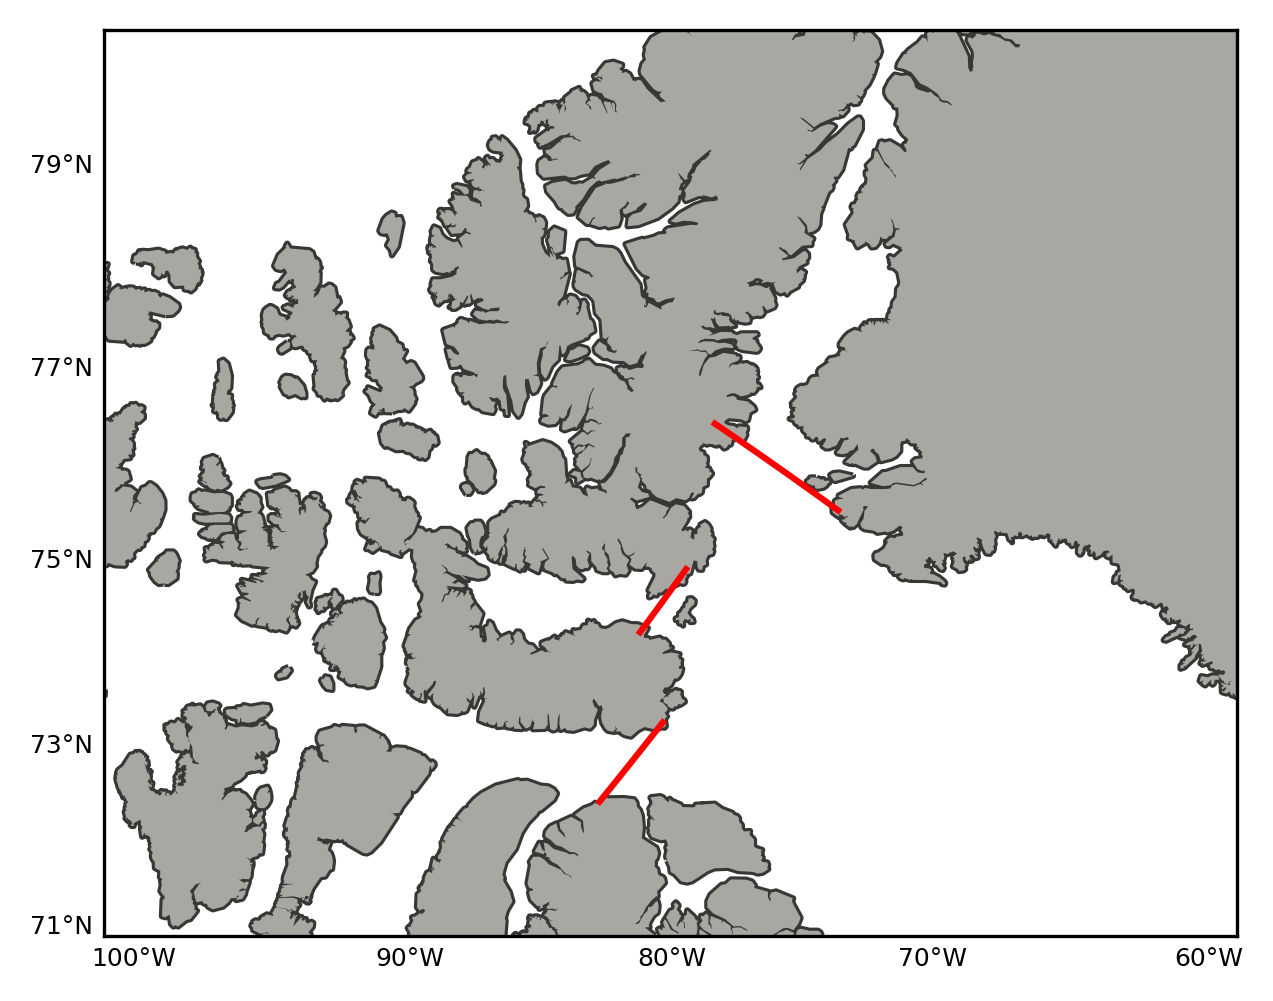

In [4]:
fig, ax1 = plt.subplots(figsize=(5, 4), dpi=300)

proj1 = Basemap(projection='stere',lat_0 = 77.5, lon_0 = -80, resolution='i', width=1.5e6, height=1.2e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=6)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=6)
proj1.drawcoastlines(color=land_outline_color, linewidth=1.5)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

x, y = proj1(ANHA12_lons, ANHA12_lats)
proj1.plot(x[LS[0],LS[2]:LS[3]], y[LS[0],LS[2]:LS[3]], '-r', linewidth=1.5) # Lancaster Sound
proj1.plot(x[NS[0]:NS[1],NS[2]], y[NS[0]:NS[1],NS[2]], '-r', linewidth=1.5) # Nares Strait
proj1.plot(x[JS[0],JS[2]:JS[3]], y[JS[0],JS[2]:JS[3]], '-r', linewidth=1.5) # Jones Sound

fig.savefig('/ocean/brogalla/GEOTRACES/figures/SK_boundaries.jpg', dpi=300, bbox_inches='tight')

#### Calculate transport

In [51]:
def load_flux(year):
    # Load volume flux for a particular year:
    
    ts = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/time-series/Stephan-2022-transport/time-series-{year}.nc')
    ts_LS = ts['transport_LS'].values
    ts_NS = ts['transport_NS'].values
    ts_JS = ts['transport_JS'].values
    
    # Split into upper and lower water column
    split1 = 18 # depth level at which the upper split happens (48 m)
    split2 = 22 # depth level at which the lower split happens (92 m)
    
    # Net export across each cross section: sum of all negative and positive volume fluxes
    # Jones Sound:
    upper_JS = ts_JS[:,0:split1,:].sum(axis=(1,2))
    mid_JS   = ts_JS[:,split1:split2,:].sum(axis=(1,2))
    lower_JS = ts_JS[:,split2:,:].sum(axis=(1,2))
    
    # Nares Strait:
    upper_NS = ts_NS[:,0:split1,:].sum(axis=(1,2))
    mid_NS   = ts_NS[:,split1:split2,:].sum(axis=(1,2))
    lower_NS = ts_NS[:,split2:,:].sum(axis=(1,2))
    
    # Lancaster Sound:
    upper_LS = ts_LS[:,0:split1,:].sum(axis=(1,2))
    mid_LS   = ts_LS[:,split1:split2,:].sum(axis=(1,2))
    lower_LS = ts_LS[:,split2:,:].sum(axis=(1,2))
        
    return upper_JS, mid_JS, lower_JS, upper_NS, mid_NS, lower_NS, upper_LS, mid_LS, lower_LS

In [52]:
def create_time_series(year_start, year_end):
    # calls volume flux loader for multiple years
    time_outline = pd.date_range(start=f'2002-01-05', periods=73, freq='5D')
        
    uJS = np.empty([]); mJS = np.empty([]); lJS = np.empty([]);
    uNS = np.empty([]); mNS = np.empty([]); lNS = np.empty([]); 
    uLS = np.empty([]); mLS = np.empty([]); lLS = np.empty([]);
    time_series=[]
    # load transports and calculate the sum of the transport across the boundary:
    for year in range(year_start, year_end+1):
        time_series_year = [time.replace(year=year) for time in time_outline]
        time_series = time_series + time_series_year
                               
        upperJS, middleJS, lowerJS, upperNS, middleNS, lowerNS, upperLS, middleLS, lowerLS = load_flux(year)
        uJS = np.append(uJS, upperJS); mJS = np.append(mJS, middleJS); lJS = np.append(lJS, lowerJS);
        uNS = np.append(uNS, upperNS); mNS = np.append(mNS, middleNS); lNS = np.append(lNS, lowerNS)
        uLS = np.append(uLS, upperLS); mLS = np.append(mLS, middleLS); lLS = np.append(lLS, lowerLS)
        
    return pd.to_datetime(time_series), uJS[1:], mJS[1:], lJS[1:], uNS[1:], mNS[1:], lNS[1:], uLS[1:], mLS[1:], lLS[1:]

In [53]:
def calculate_monthly_flux(time_series, ubdy, mbdy, lbdy):
    # Calculate monthly volume flux over the full time series for three depth ranges: upper, middle, lower
    days_in_month = [monthrange(2002,mth)[1] for mth in range(1,13)] # base number of days in a month on 2002 to avoid leap year
      
    num_years  = len(np.unique(time_series.year))
    num_months = len(np.unique(time_series.month))
    monthly_ubdy_ave = np.empty((num_years*num_months))
    monthly_mbdy_ave = np.empty((num_years*num_months))
    monthly_lbdy_ave = np.empty((num_years*num_months))
    # Calculate average for each month, taking into account that each date is based on a 5-day file that may or may not
    # start and end in the current month
    i=0; dates = [];
    for year in np.unique(time_series.year):
        for month in range(1,13):
            monthly_ubdy_sum = 0; monthly_mbdy_sum = 0; monthly_lbdy_sum = 0;
            sum_days=0
            max_day = time_series[(time_series.year==year) & (time_series.month==month)][-1].day
            dates.append(f'{year}-{month:02}')
            
            for d, date in enumerate(time_series): 
                if (date.year == year) &  (date.month == month) & (date.day - 5 >= 0) & (date.day <= days_in_month[month-1]):
                    monthly_ubdy_sum += ubdy[d]*(5) # since these are five-day files
                    monthly_mbdy_sum += mbdy[d]*(5)
                    monthly_lbdy_sum += lbdy[d]*(5)

                    sum_days +=5
#                     print(f'Normal case: {date}, multiply by 5')
                elif (date.year == year) & (date.month == month) & (date.day - 5 < 0):
                    monthly_ubdy_sum += ubdy[d]*(date.day)
                    monthly_mbdy_sum += mbdy[d]*(date.day)
                    monthly_lbdy_sum += lbdy[d]*(date.day)

                    sum_days += date.day
#                     print(f'Start of month: {date}, multiply by {date.day}')
                elif (date.year == year) & (date.month == month+1) & (date.day - 5 < 0):
                    monthly_ubdy_sum += ubdy[d]*(days_in_month[month-1] - max_day)
                    monthly_mbdy_sum += mbdy[d]*(days_in_month[month-1] - max_day)
                    monthly_lbdy_sum += lbdy[d]*(days_in_month[month-1] - max_day)

                    sum_days += (days_in_month[month-1] - max_day)
#                     print(f'End of month: {date}, multiply by {(days_in_month[month-1] - max_day)}')
        
            monthly_ubdy_ave[i] = monthly_ubdy_sum / sum_days
            monthly_mbdy_ave[i] = monthly_mbdy_sum / sum_days
            monthly_lbdy_ave[i] = monthly_lbdy_sum / sum_days
            
            i+=1
    
    return dates, monthly_ubdy_ave*1e-6, monthly_mbdy_ave*1e-6, monthly_lbdy_ave*1e-6 # convert to sverdrup

In [54]:
def plot_flux(time_series, uJS, mJS, lJS, uNS, mNS, lNS, uLS, mLS, lLS):
    # Create 4 subplots showing the time series of volume flux across each of the boundaries

    colors = ['#ceda90','#8fa484','#75a3b1']
    
    fig, ax = plt.subplots(3,1, figsize=(8,7), dpi=300)

    ax[0].plot([time_series[0], time_series[-1]], [0,0], '-k', linewidth=0.8)
    ax[0].plot(time_series, uLS*1e-6, label='upper 47 m', linewidth=0.9, c=colors[0])
    ax[0].plot(time_series, mLS*1e-6, label='47-92 m', linewidth=0.9, c=colors[1])
    ax[0].plot(time_series, lLS*1e-6, label='below 92 m', linewidth=0.9, c=colors[2])
    ax[0].plot(time_series, (uLS+mLS+lLS)*1e-6, c='k', label='sum', linewidth=1.2)
    ax[0].set_title('Lancaster Sound', fontsize=7)    

    ax[1].plot([time_series[0], time_series[-1]], [0,0], '-k', linewidth=0.8)
    ax[1].plot(time_series, uJS*1e-6, label='upper', linewidth=0.9, c=colors[0])
    ax[1].plot(time_series, mJS*1e-6, label='middle', linewidth=0.9, c=colors[1])
    ax[1].plot(time_series, lJS*1e-6, label='lower', linewidth=0.9, c=colors[2])
    ax[1].plot(time_series, (uJS+mJS+lJS)*1e-6, c='k', label='sum', linewidth=1.2)
    ax[1].set_title('Jones Sound', fontsize=7)
    
    ax[2].plot([time_series[0], time_series[-1]], [0,0], '-k', linewidth=0.8)
    ax[2].plot(time_series, uNS*1e-6, label='upper', linewidth=0.9, c=colors[0])
    ax[2].plot(time_series, mNS*1e-6, label='middle', linewidth=0.9, c=colors[1])
    ax[2].plot(time_series, lNS*1e-6, label='lower', linewidth=0.9, c=colors[2])
    ax[2].plot(time_series, (uNS+mNS+lNS)*1e-6, c='k', label='sum', linewidth=1.2)
    ax[2].set_title('Nares Strait', fontsize=7)
    
    for axis in ax.ravel():
        axis.tick_params(labelsize=6.5)
        axis.set_xlim(time_series[0], time_series[-1])
#         axis.set_xlim(time_series[108], time_series[202])
        axis.xaxis.set_minor_locator(mpl_dates.MonthLocator())
        axis.set_ylabel('Transport (Sv)', fontsize=6.5)
        
    lg = ax[0].legend(fontsize=6.5)
    for line in lg.get_lines():
        line.set_linewidth(2.0)
        
    ax[0].set_ylim(-2, 0.5)
    ax[1].set_ylim(-0.25, 0.25)
    ax[2].set_ylim(-2, 0.5)
        
    plt.tight_layout()
    
#     fig.savefig('/ocean/brogalla/GEOTRACES/figures/transport_2015-2016.jpg', dpi=300, bbox_inches='tight')
    return

In [55]:
time_series, uJS, mJS, lJS, uNS, mNS, lNS, uLS, mLS, lLS = create_time_series(2004, 2010)

In [56]:
dates, uJS_sum, mJS_sum, lJS_sum, = calculate_monthly_flux(time_series, uJS, mJS, lJS)
dates, uNS_sum, mNS_sum, lNS_sum, = calculate_monthly_flux(time_series, uNS, mNS, lNS)
dates, uLS_sum, mLS_sum, lLS_sum, = calculate_monthly_flux(time_series, uLS, mLS, lLS)

In [23]:
i = 0; j = 84;
print('Lancaster Sound')
for date in range(i,j):
    print(f'{dates[date]}, {uLS_sum[date]:.2f}, {mLS_sum[date]:.2f}, {lLS_sum[date]:.2f}, {(uLS_sum[date]+mLS_sum[date]+lLS_sum[date]):.2f}')
print(f'Mean:    {uLS_sum[i:j].mean():.2f} {mLS_sum[i:j].mean():.2f} {lLS_sum[i:j].mean():.2f} {(uLS_sum[i:j]+mLS_sum[i:j]+lLS_sum[i:j]).mean():.2f}')

print('Jones Sound')
for date in range(i,j):
    print(f'{dates[date]}, {uJS_sum[date]:.2f}, {mJS_sum[date]:.2f}, {lJS_sum[date]:.2f}, {(uJS_sum[date]+mJS_sum[date]+lJS_sum[date]):.2f}')
print(f'Mean:    {uJS_sum[i:j].mean():.2f} {mJS_sum[i:j].mean():.2f} {lJS_sum[i:j].mean():.2f} {(uJS_sum[i:j]+mJS_sum[i:j]+lJS_sum[i:j]).mean():.2f}')
    
print('Nares Strait')
for date in range(i,j):
    print(f'{dates[date]}, {uNS_sum[date]:.2f}, {mNS_sum[date]:.2f}, {lNS_sum[date]:.2f}, {(uNS_sum[date]+mNS_sum[date]+lNS_sum[date]):.2f}')
print(f'Mean:    {uNS_sum[i:j].mean():.2f} {mNS_sum[i:j].mean():.2f} {lNS_sum[i:j].mean():.2f} {(uNS_sum[i:j]+mNS_sum[i:j]+lNS_sum[i:j]).mean():.2f}')

Lancaster Sound
2004-01, -0.21, -0.16, -0.31, -0.68
2004-02, -0.31, -0.22, -0.45, -0.98
2004-03, -0.40, -0.30, -0.63, -1.33
2004-04, -0.32, -0.26, -0.32, -0.90
2004-05, -0.30, -0.23, -0.31, -0.84
2004-06, -0.32, -0.25, -0.51, -1.08
2004-07, -0.38, -0.31, -0.65, -1.34
2004-08, -0.38, -0.35, -0.71, -1.43
2004-09, -0.33, -0.35, -0.60, -1.28
2004-10, -0.18, -0.22, -0.33, -0.73
2004-11, -0.21, -0.19, -0.09, -0.49
2004-12, -0.23, -0.16, -0.35, -0.74
2005-01, -0.30, -0.21, -0.56, -1.06
2005-02, -0.37, -0.25, -0.44, -1.07
2005-03, -0.31, -0.20, -0.27, -0.79
2005-04, -0.38, -0.25, -0.59, -1.22
2005-05, -0.35, -0.24, -0.41, -1.00
2005-06, -0.30, -0.22, -0.48, -0.99
2005-07, -0.35, -0.28, -0.64, -1.27
2005-08, -0.29, -0.28, -0.64, -1.20
2005-09, -0.26, -0.28, -0.55, -1.08
2005-10, -0.18, -0.20, -0.42, -0.80
2005-11, -0.24, -0.21, -0.36, -0.81
2005-12, -0.27, -0.20, -0.38, -0.85
2006-01, -0.35, -0.25, -0.64, -1.23
2006-02, -0.35, -0.28, -0.47, -1.09
2006-03, -0.35, -0.24, -0.30, -0.89
2006-04, -0.

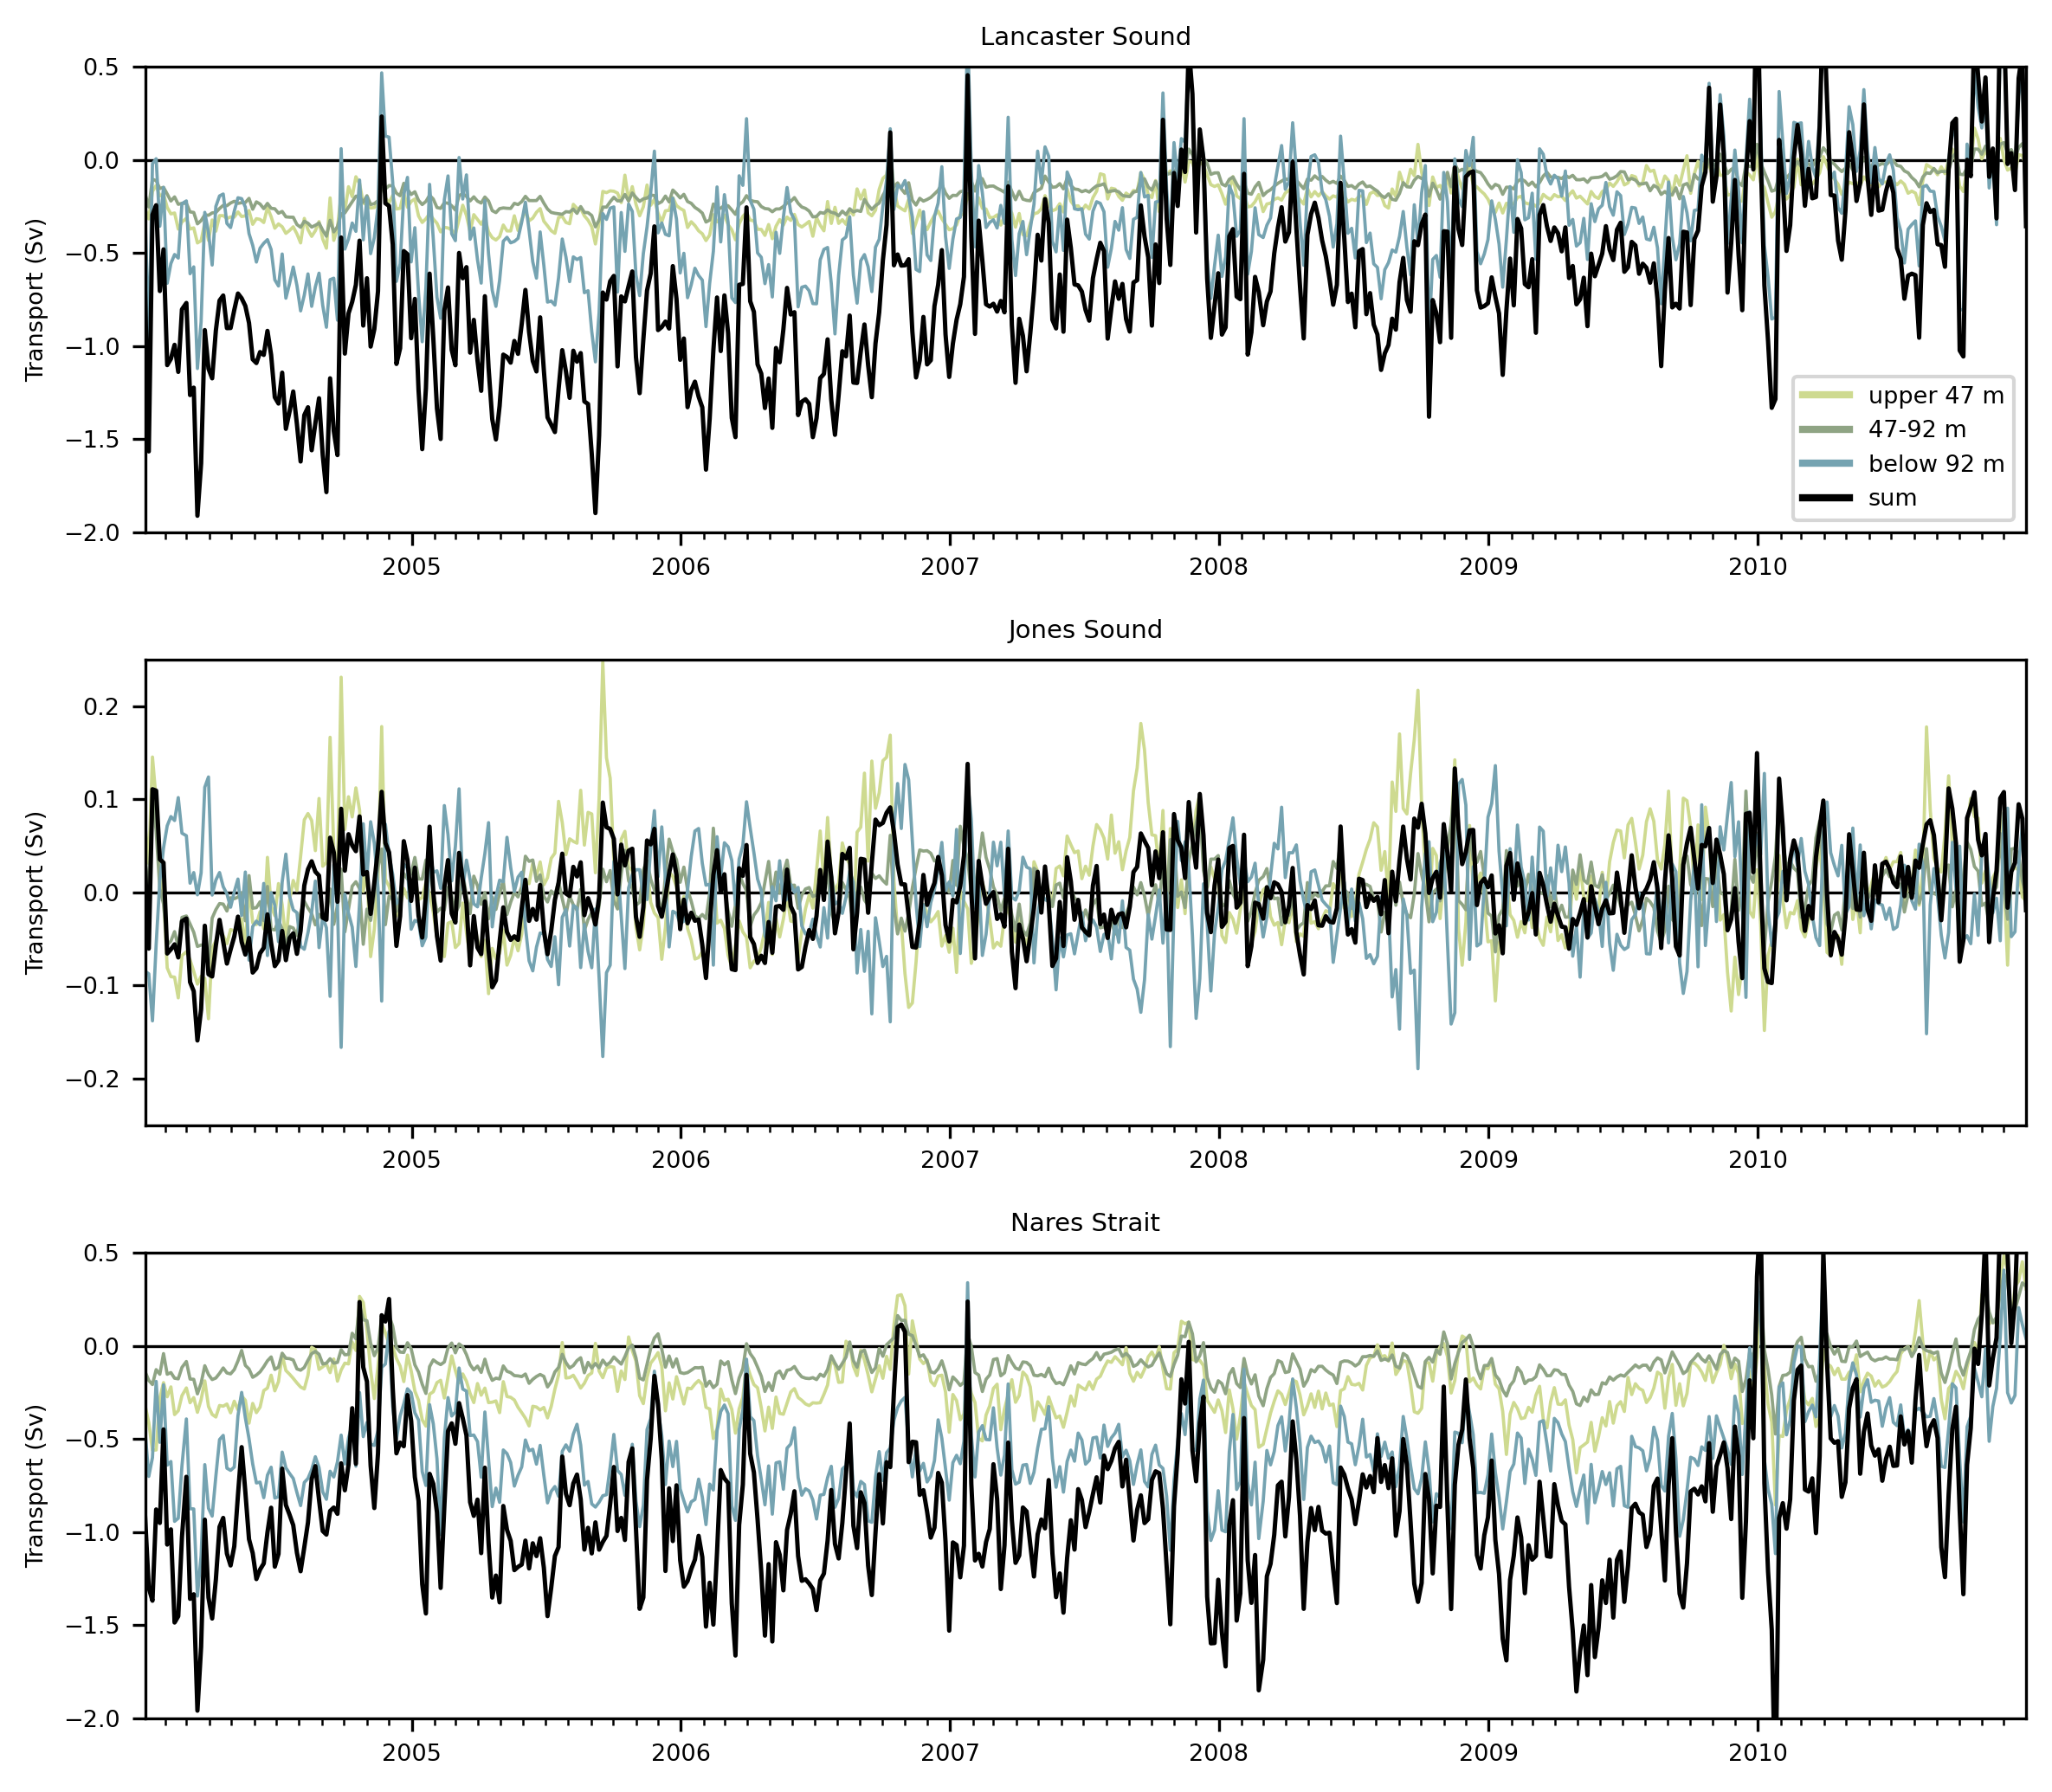

In [10]:
plot_flux(time_series, uJS, mJS, lJS, uNS, mNS, lNS, uLS, mLS, lLS)

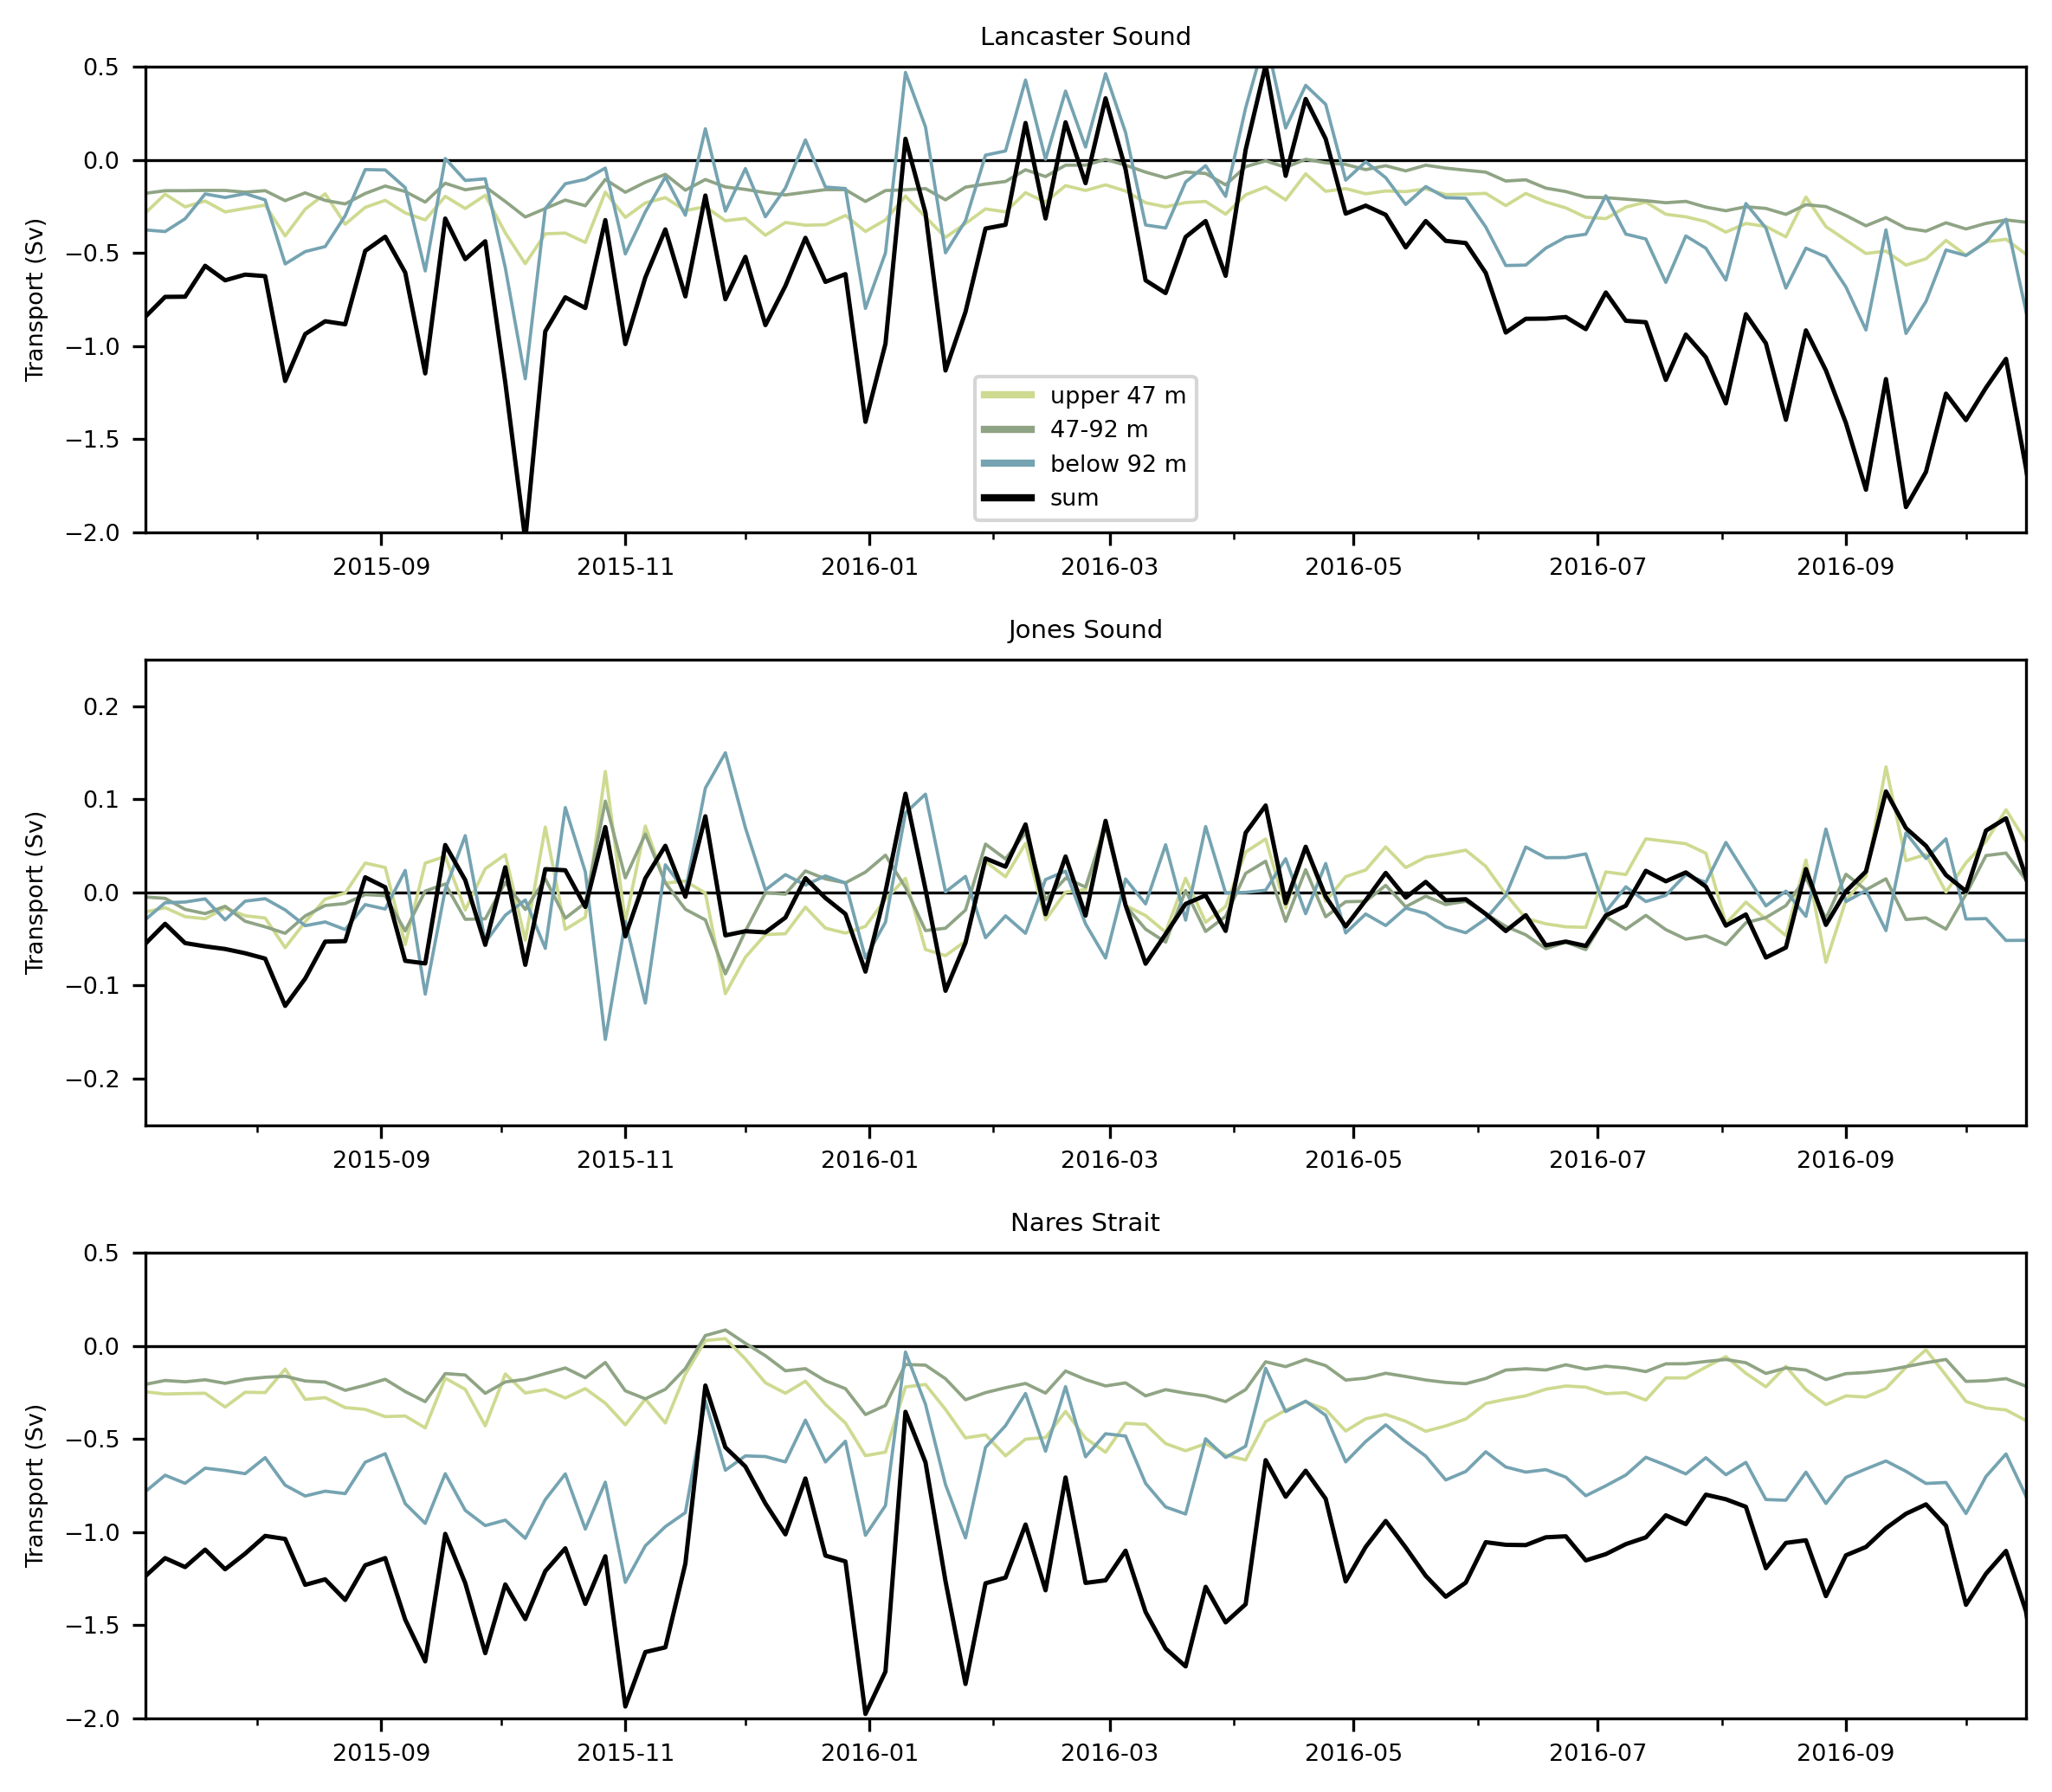

In [12]:
plot_flux(time_series, uJS, mJS, lJS, uNS, mNS, lNS, uLS, mLS, lLS)

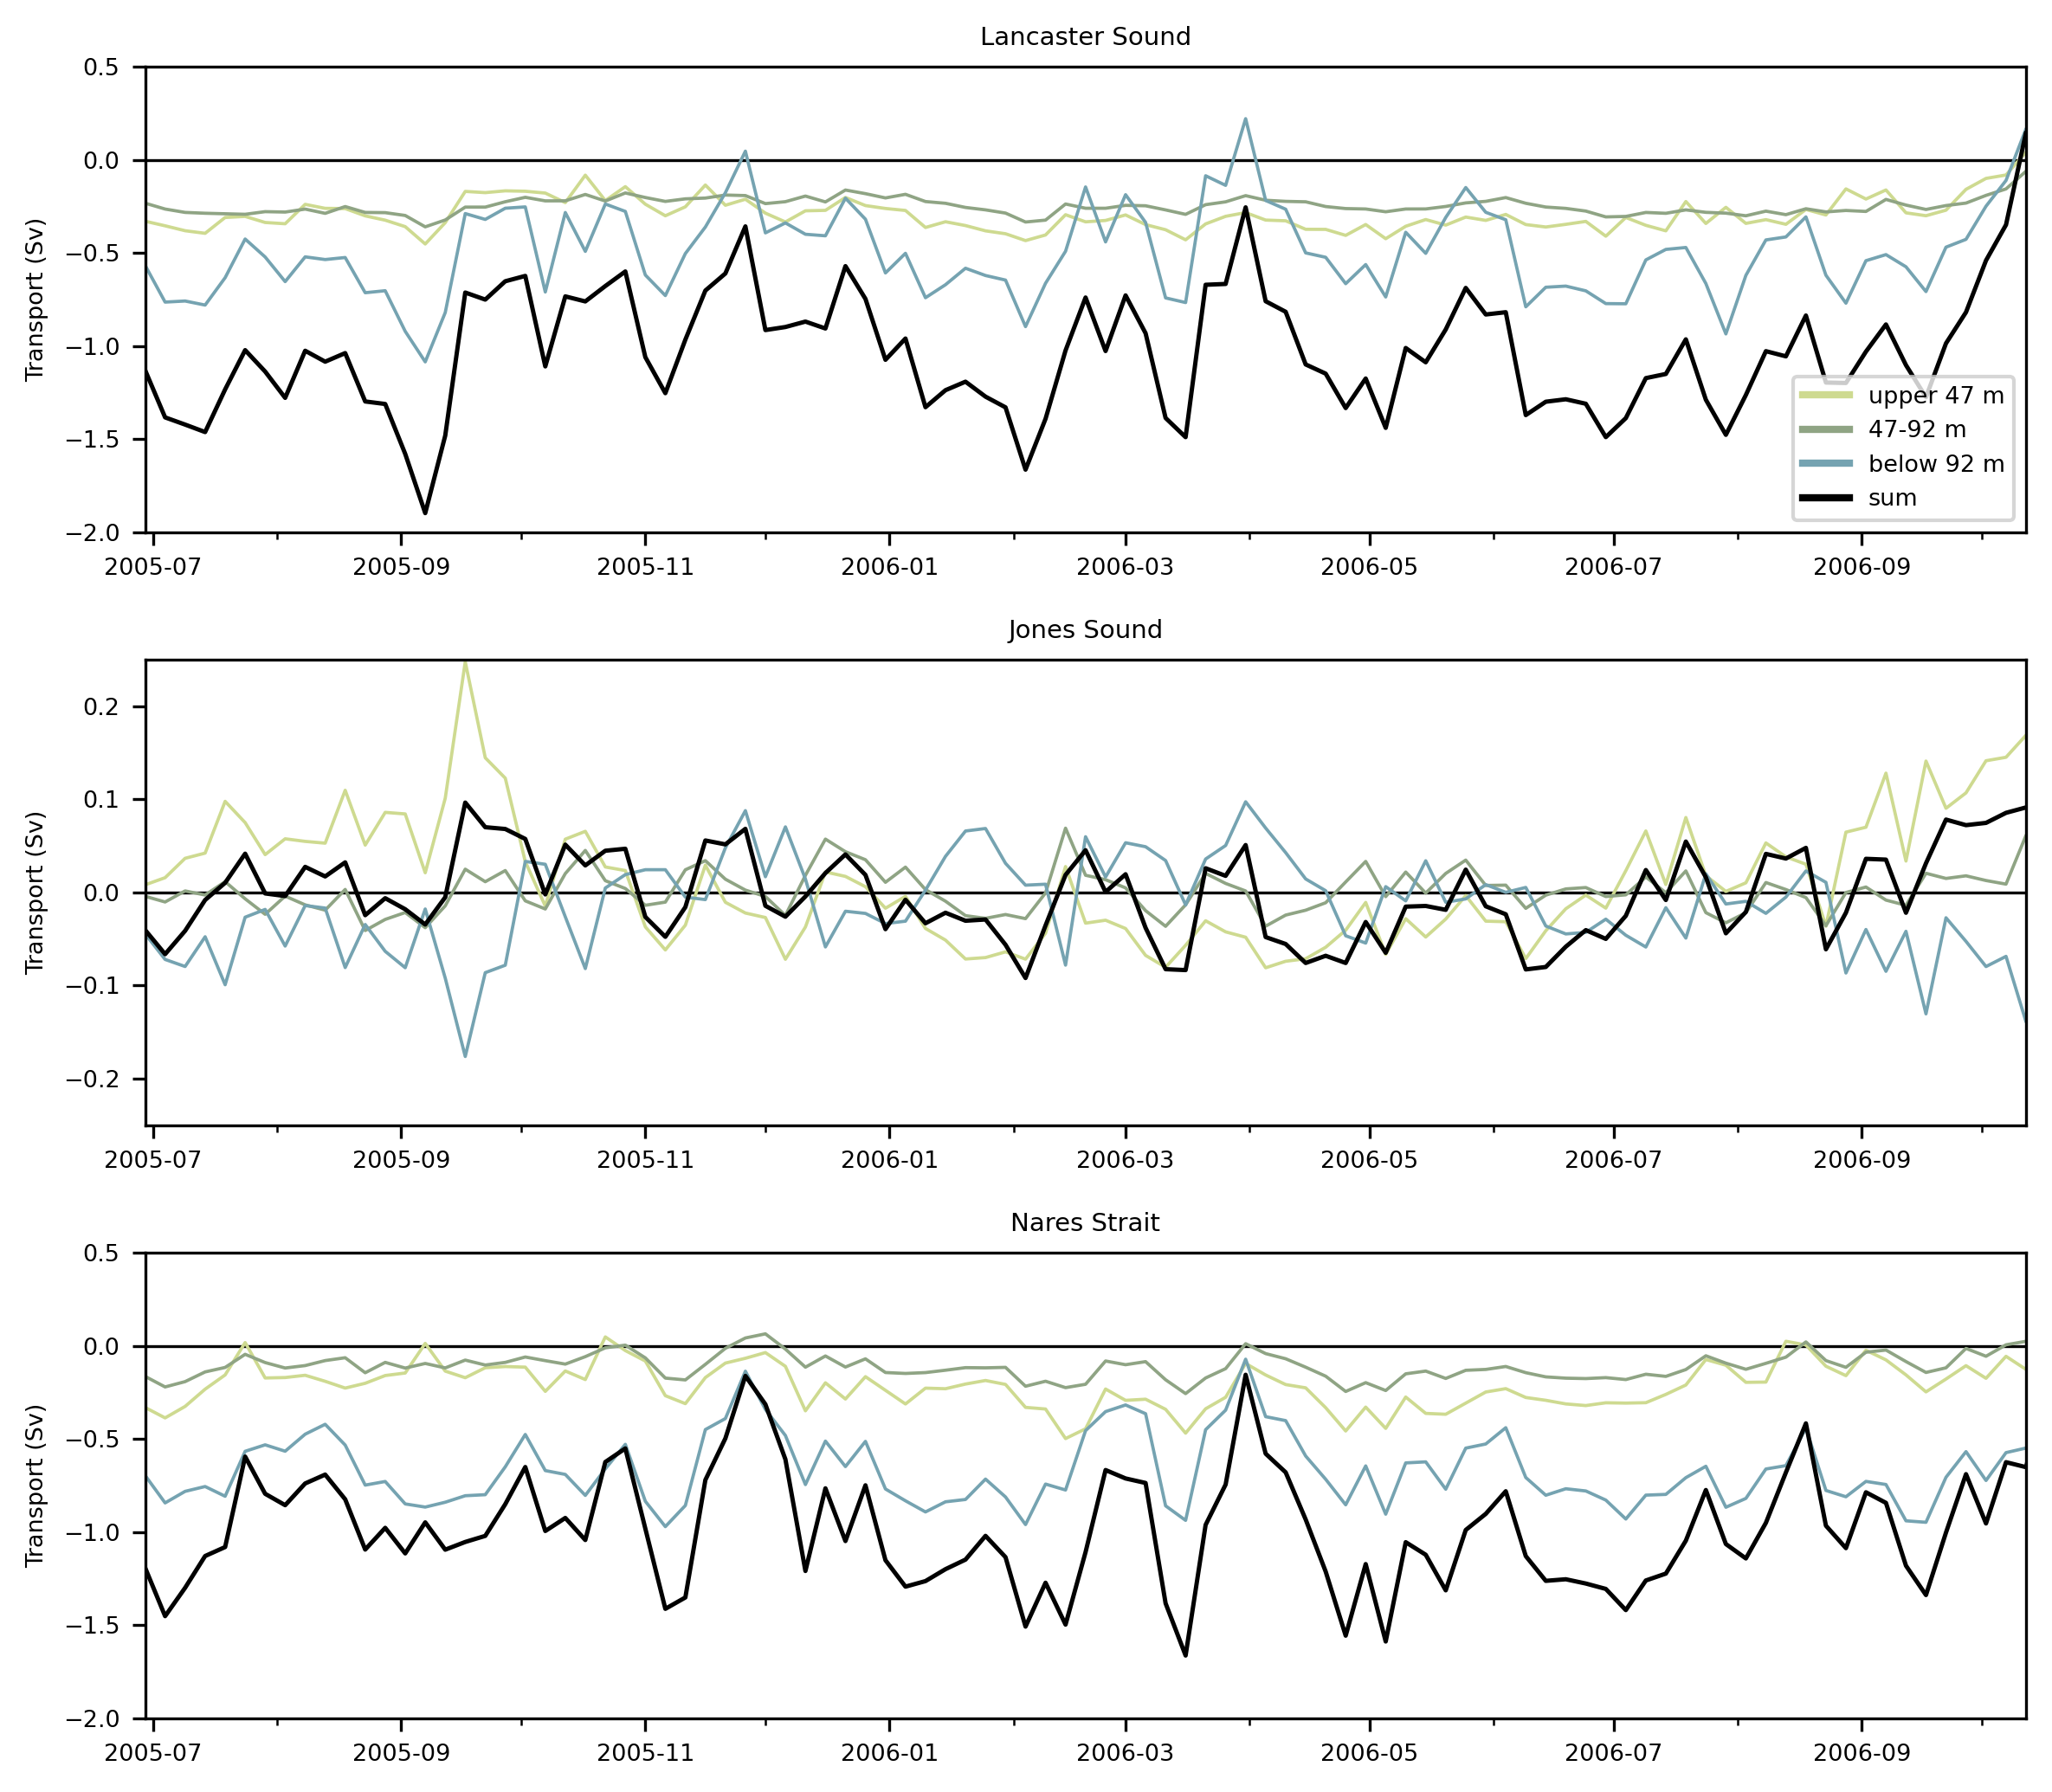

In [42]:
plot_flux(time_series, uJS, mJS, lJS, uNS, mNS, lNS, uLS, mLS, lLS)

#### Look at water masses at these boundaries

In [13]:
def load_climatology(date):        
    # load year 2015 climatology of ANHA12 gridT file:
    df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/new_averages/gridT_{date[0:4]}_{date[4:6]}.nc')
    
    bdy_temp = df_gridT['votemper'].values[:,:,:]
    bdy_sal  = df_gridT['vosaline'].values[:,:,:]
    
    return bdy_temp, bdy_sal

In [14]:
# dates = ['200509', '200510', '200511', '200512', '200601', '200602', '200603', '200604', '200605', '200606', '200607', '200608']
dates = ['201509', '201510', '201511', '201512', '201601', '201602', '201603', '201604', '201605', '201606', '201607', '201608']

# For each boundary create an array of temperature and salinity with shape (month, depth level, position along boundary)
NS_T = np.empty((len(dates), 50, NS_len)); NS_S = np.empty((len(dates), 50, NS_len));
LS_T = np.empty((len(dates), 50, LS_len)); LS_S = np.empty((len(dates), 50, LS_len));
JS_T = np.empty((len(dates), 50, JS_len)); JS_S = np.empty((len(dates), 50, JS_len));

for d,date in enumerate(dates):
    
    T, S = load_climatology(date)
    
    NS_T[d,:,:] = T[:,NS[0]:NS[1],NS[2]]
    NS_S[d,:,:] = S[:,NS[0]:NS[1],NS[2]]
    LS_T[d,:,:] = T[:,LS[0],LS[2]:LS[3]]
    LS_S[d,:,:] = S[:,LS[0],LS[2]:LS[3]]
    JS_T[d,:,:] = T[:,JS[0],JS[2]:JS[3]]
    JS_S[d,:,:] = S[:,JS[0],JS[2]:JS[3]]

In [15]:
def point_density(S, T):
    
    x = S[:,:,:].flatten()
    y = T[:,:,:].flatten()

    x_m = np.ma.masked_where(np.isnan(x), x)
    y_m = np.ma.masked_where(np.isnan(y), y)

    xx = x[~x_m.mask]
    yy = y[~y_m.mask]

    # Calculate the point density
    xy = np.vstack([xx,yy])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = xx[idx], yy[idx], z[idx]
    
    return np.array(x), np.array(y), z

In [16]:
xNS, yNS, zNS = point_density(NS_S, NS_T)
xLS, yLS, zLS = point_density(LS_S, LS_T)
xJS, yJS, zJS = point_density(JS_S, JS_T)

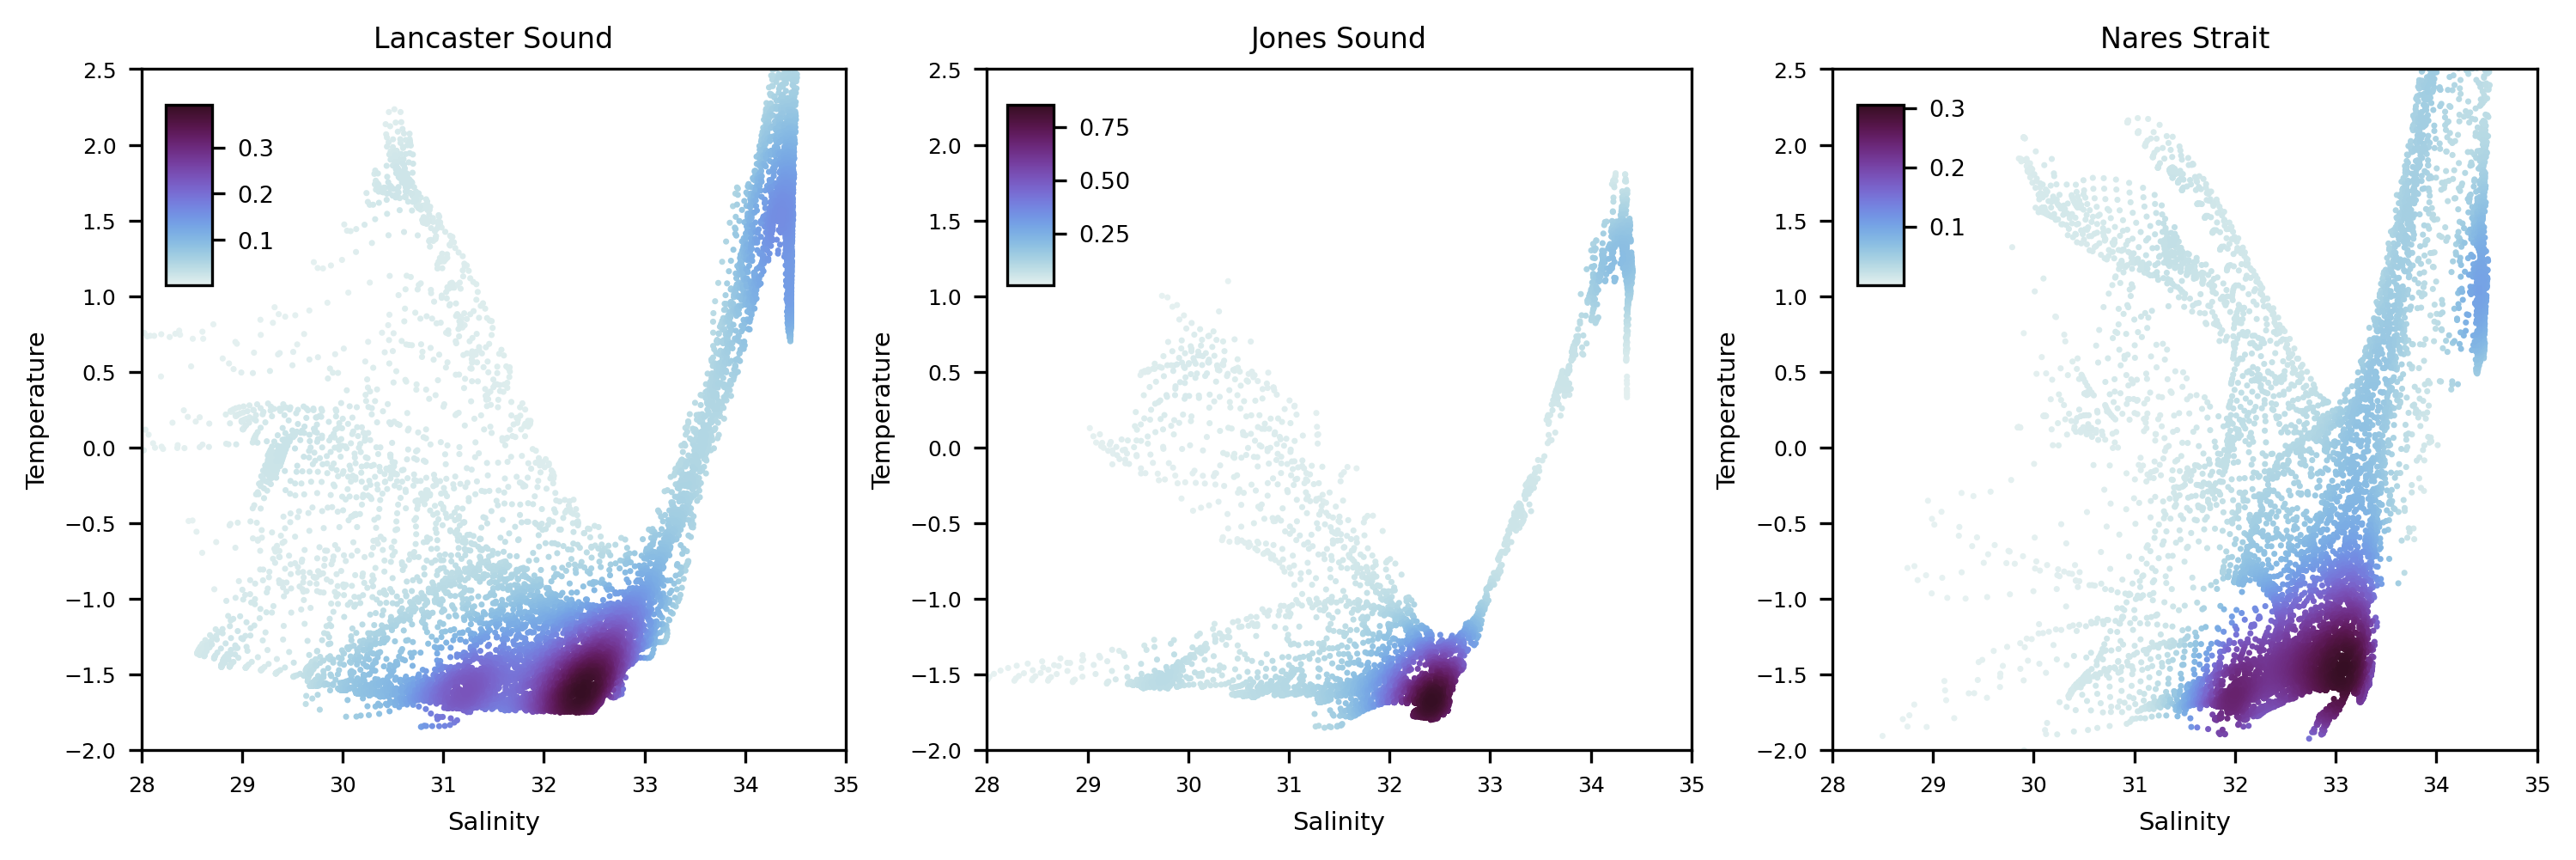

In [18]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5), dpi=300)

ax[0].set_title('Lancaster Sound', fontsize=8)
ax[1].set_title('Jones Sound', fontsize=8)
ax[2].set_title('Nares Strait', fontsize=8)

for n,axis in enumerate(ax.ravel()):
    axis.set_xlabel('Salinity', fontsize=7)
    axis.set_ylabel('Temperature', fontsize=7)
    axis.tick_params(labelsize=6)
    axis.set_xlim(28, 35)
    axis.set_ylim(-2.0, 2.5)
    
C1 = ax[0].scatter(xLS, yLS, c=zLS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)
C2 = ax[1].scatter(xJS, yJS, c=zJS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)
C3 = ax[2].scatter(xNS, yNS, c=zNS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)

cbaxes1 = fig.add_axes([0.133, 0.64, 0.015, 0.2]) 
cbaxes2 = fig.add_axes([0.405, 0.64, 0.015, 0.2]) 
cbaxes3 = fig.add_axes([0.680, 0.64, 0.015, 0.2]) 
CB1 = plt.colorbar(C1, cax=cbaxes1)
CB2 = plt.colorbar(C2, cax=cbaxes2)
CB3 = plt.colorbar(C3, cax=cbaxes3)
for CBar in [CB1, CB2, CB3]:
    CBar.ax.tick_params(labelsize=6.5)
#     CBar.ax.set_label('Depth [m]')    

# plt.tight_layout(h_pad = 0.2)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/boundary_2015-2016_monthly_TS.jpg', dpi=300, bbox_inches='tight')

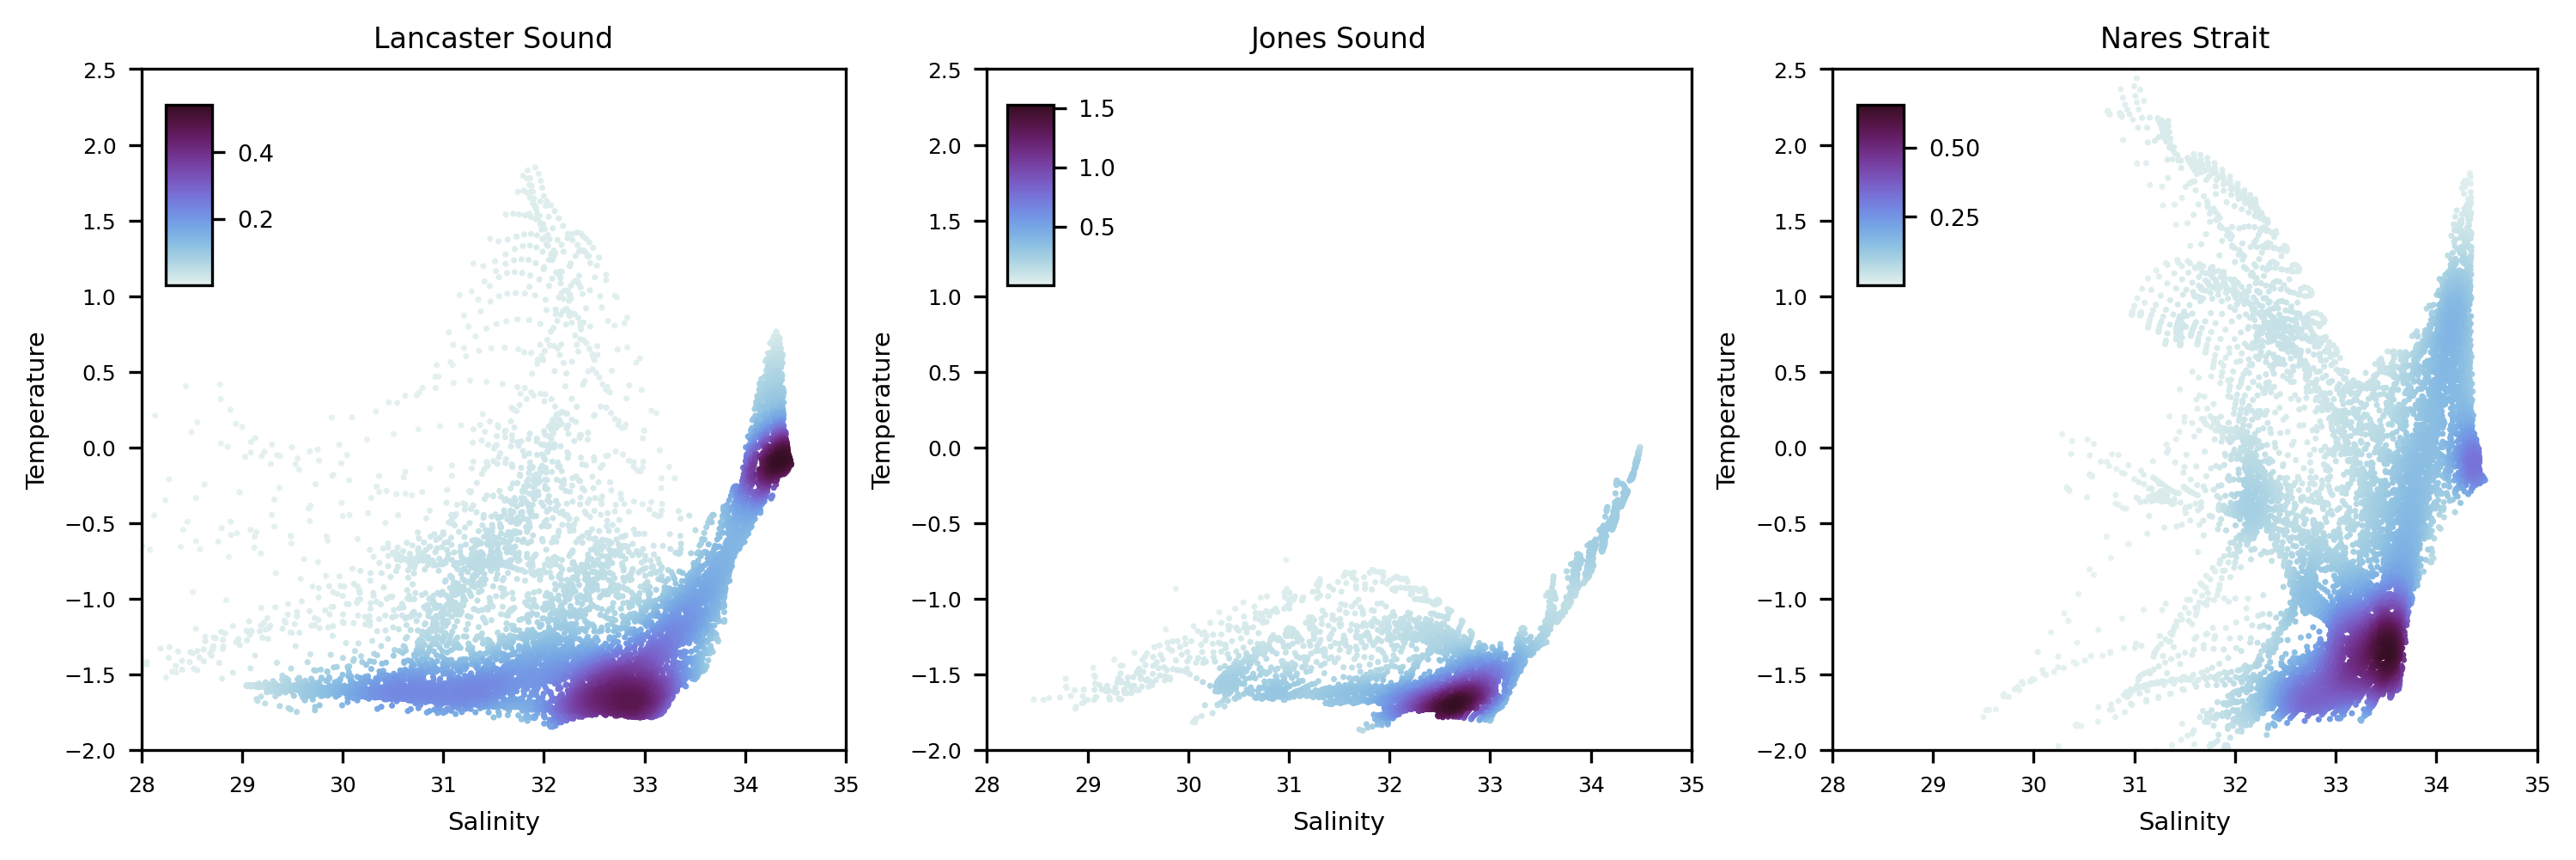

In [175]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5), dpi=300)

ax[0].set_title('Lancaster Sound', fontsize=8)
ax[1].set_title('Jones Sound', fontsize=8)
ax[2].set_title('Nares Strait', fontsize=8)

for n,axis in enumerate(ax.ravel()):
    axis.set_xlabel('Salinity', fontsize=7)
    axis.set_ylabel('Temperature', fontsize=7)
    axis.tick_params(labelsize=6)
    axis.set_xlim(28, 35)
    axis.set_ylim(-2.0, 2.5)
    
C1 = ax[0].scatter(xLS, yLS, c=zLS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)
C2 = ax[1].scatter(xJS, yJS, c=zJS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)
C3 = ax[2].scatter(xNS, yNS, c=zNS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)

cbaxes1 = fig.add_axes([0.133, 0.64, 0.015, 0.2]) 
cbaxes2 = fig.add_axes([0.405, 0.64, 0.015, 0.2]) 
cbaxes3 = fig.add_axes([0.680, 0.64, 0.015, 0.2]) 
CB1 = plt.colorbar(C1, cax=cbaxes1)
CB2 = plt.colorbar(C2, cax=cbaxes2)
CB3 = plt.colorbar(C3, cax=cbaxes3)
for CBar in [CB1, CB2, CB3]:
    CBar.ax.tick_params(labelsize=6.5)
#     CBar.ax.set_label('Depth [m]')    

# plt.tight_layout(h_pad = 0.2)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/boundary_2005-2006_monthly_TS.jpg', dpi=300, bbox_inches='tight')

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


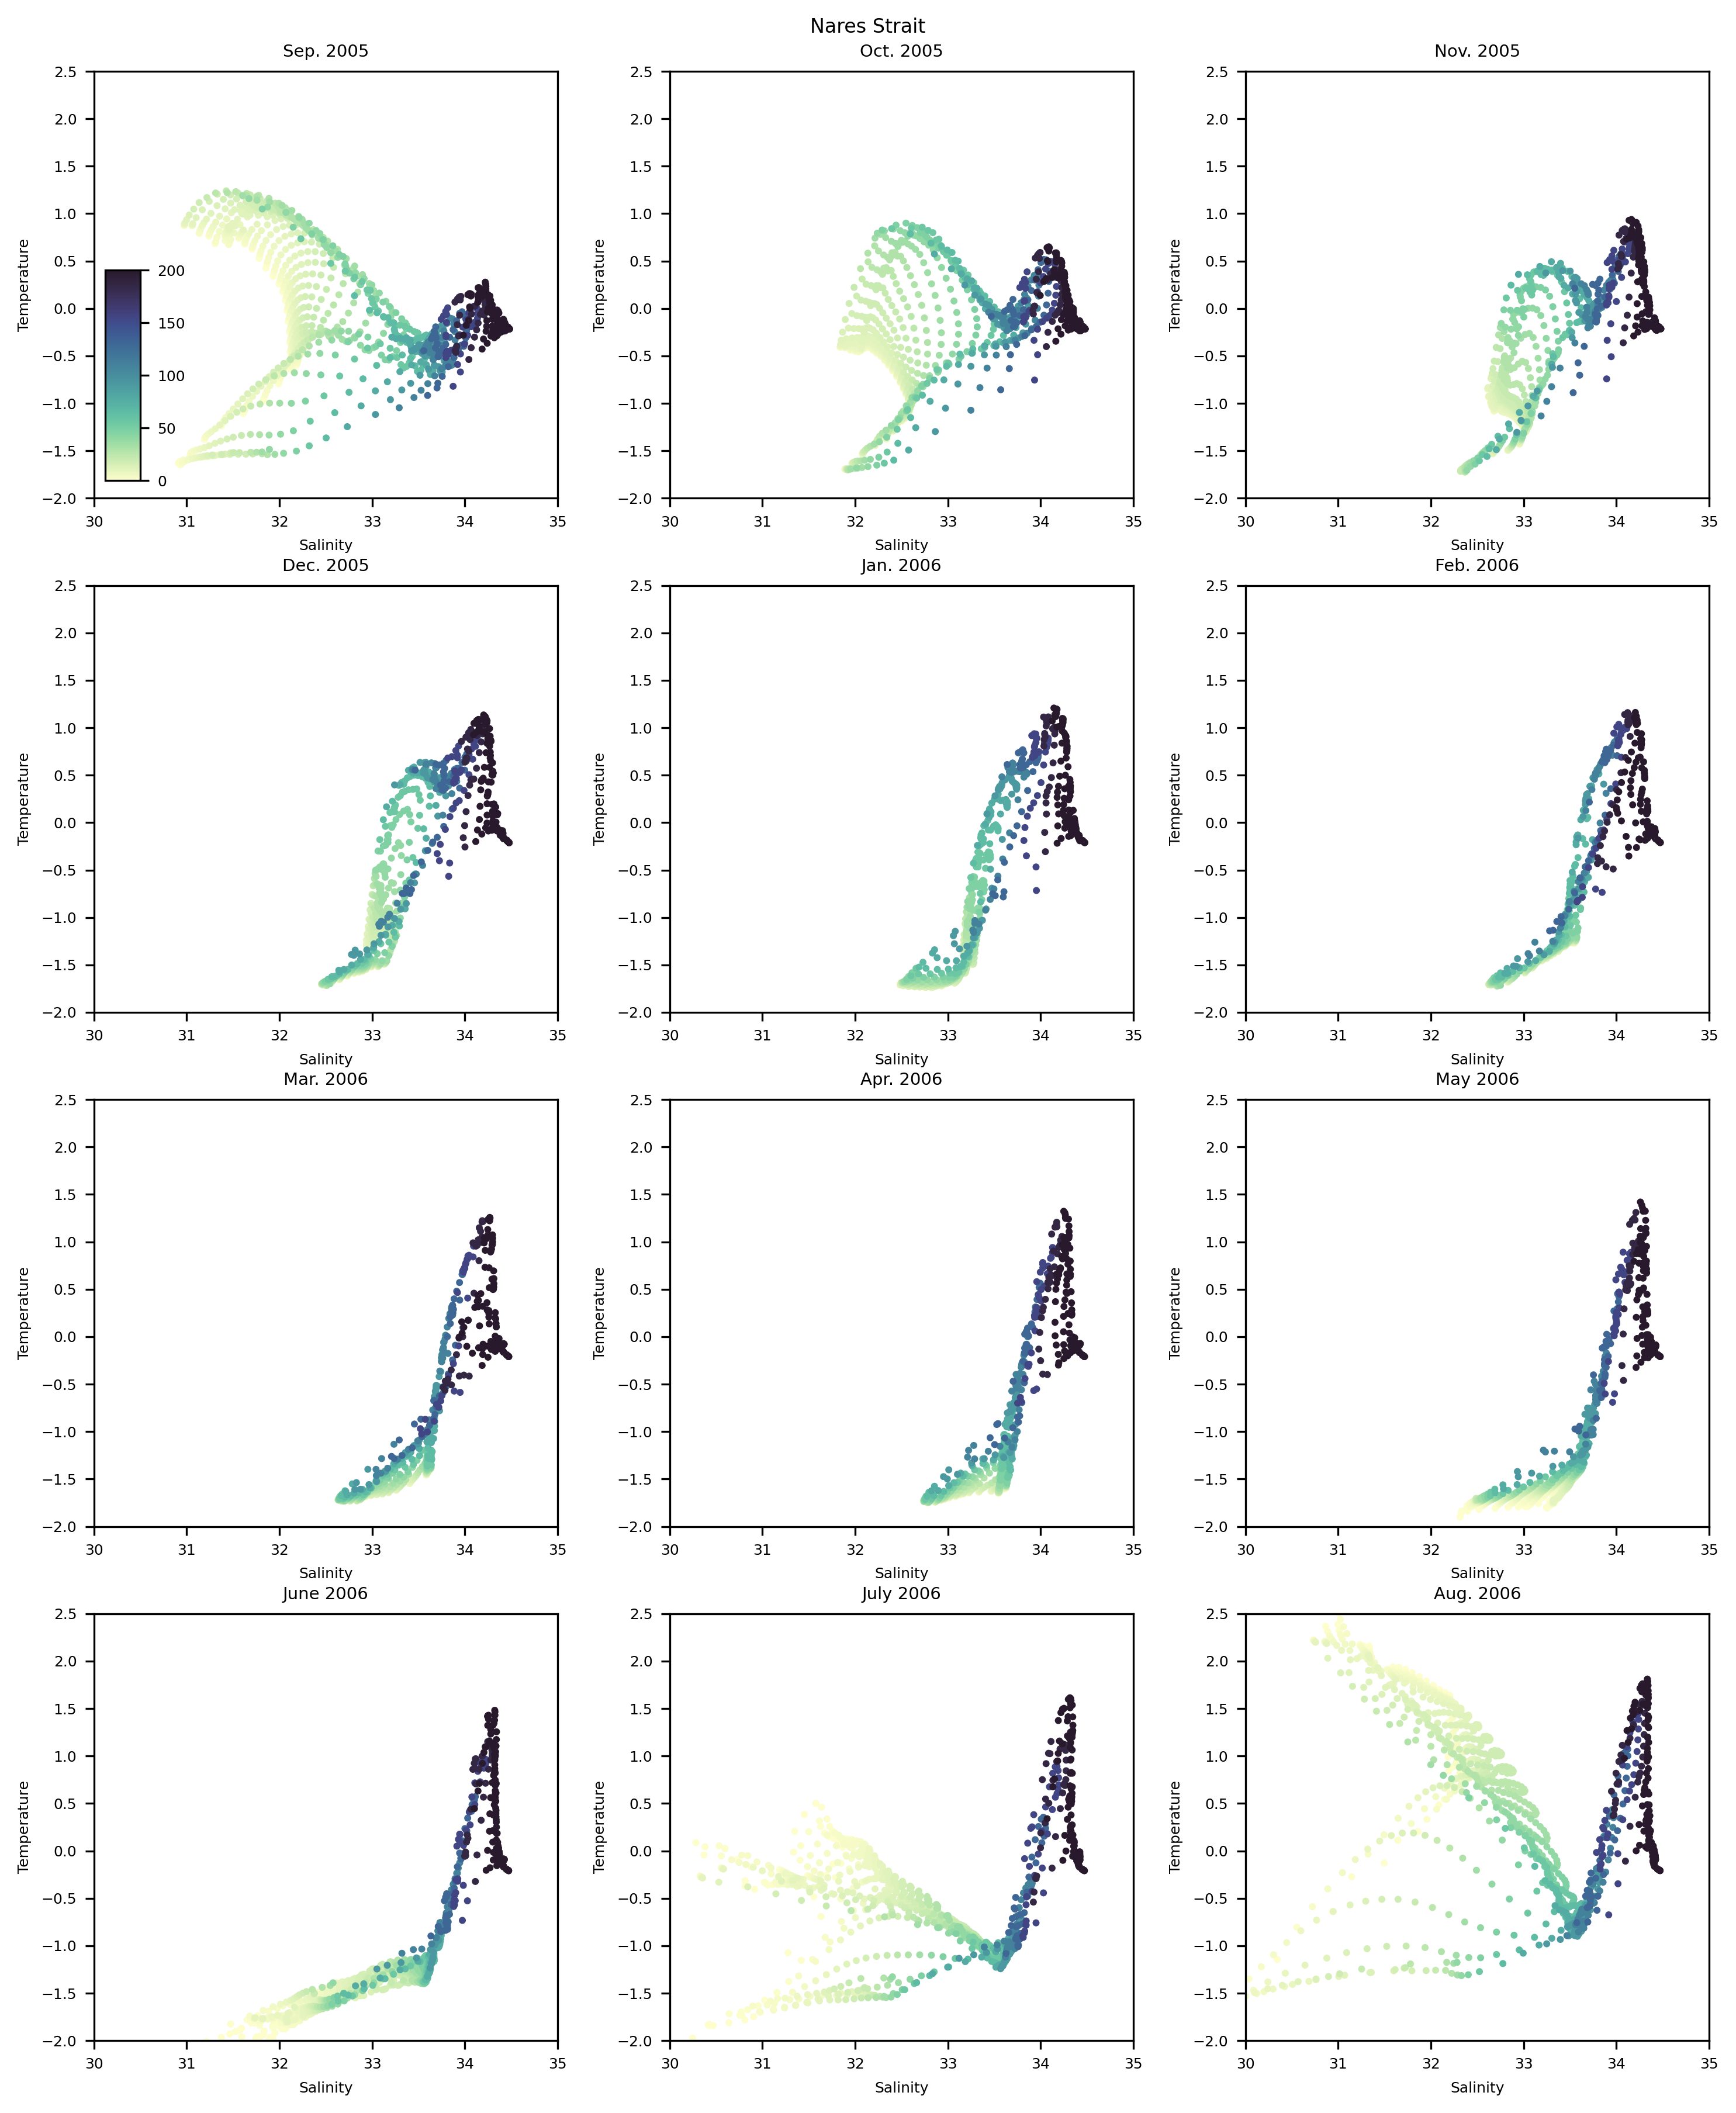

In [172]:
fig, ax = plt.subplots(4,3, figsize=(10,12), dpi=300)

fig.suptitle('Nares Strait', fontsize=8, y=1.00)

labels = ['Sep. 2005', 'Oct. 2005', 'Nov. 2005', 'Dec. 2005',\
          'Jan. 2006', 'Feb. 2006', 'Mar. 2006', 'Apr. 2006', \
          'May 2006', 'June 2006', 'July 2006', 'Aug. 2006']

for n,axis in enumerate(ax.ravel()):
    axis.set_title(labels[n], fontsize=7)
    axis.set_xlabel('Salinity', fontsize=6)
    axis.set_ylabel('Temperature', fontsize=6)
    axis.tick_params(labelsize=6)
    axis.set_xlim(30, 35)
    axis.set_ylim(-2.0, 2.5)
    
    CB = axis.scatter(NS_S[n,:,:] , NS_T[n,:,:] , c=np.tile(ANHA12_depth,(NS_T.shape[2],1)).transpose(), \
                     s=3.5, zorder=1, alpha=1, cmap=cmocean.cm.deep, vmin=0, vmax=200)
    
cbaxes1 = fig.add_axes([0.065, 0.78, 0.02, 0.1]) 
CB1 = plt.colorbar(CB, cax=cbaxes1) # ticks=np.arange(0,1.1,0.1)
CB1.ax.tick_params(labelsize=6)
CB1.ax.set_label('Depth [m]')    

plt.tight_layout(h_pad = 0.2)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/NaresStrait_2005-2006_monthly_TS.jpg', dpi=300, bbox_inches='tight')

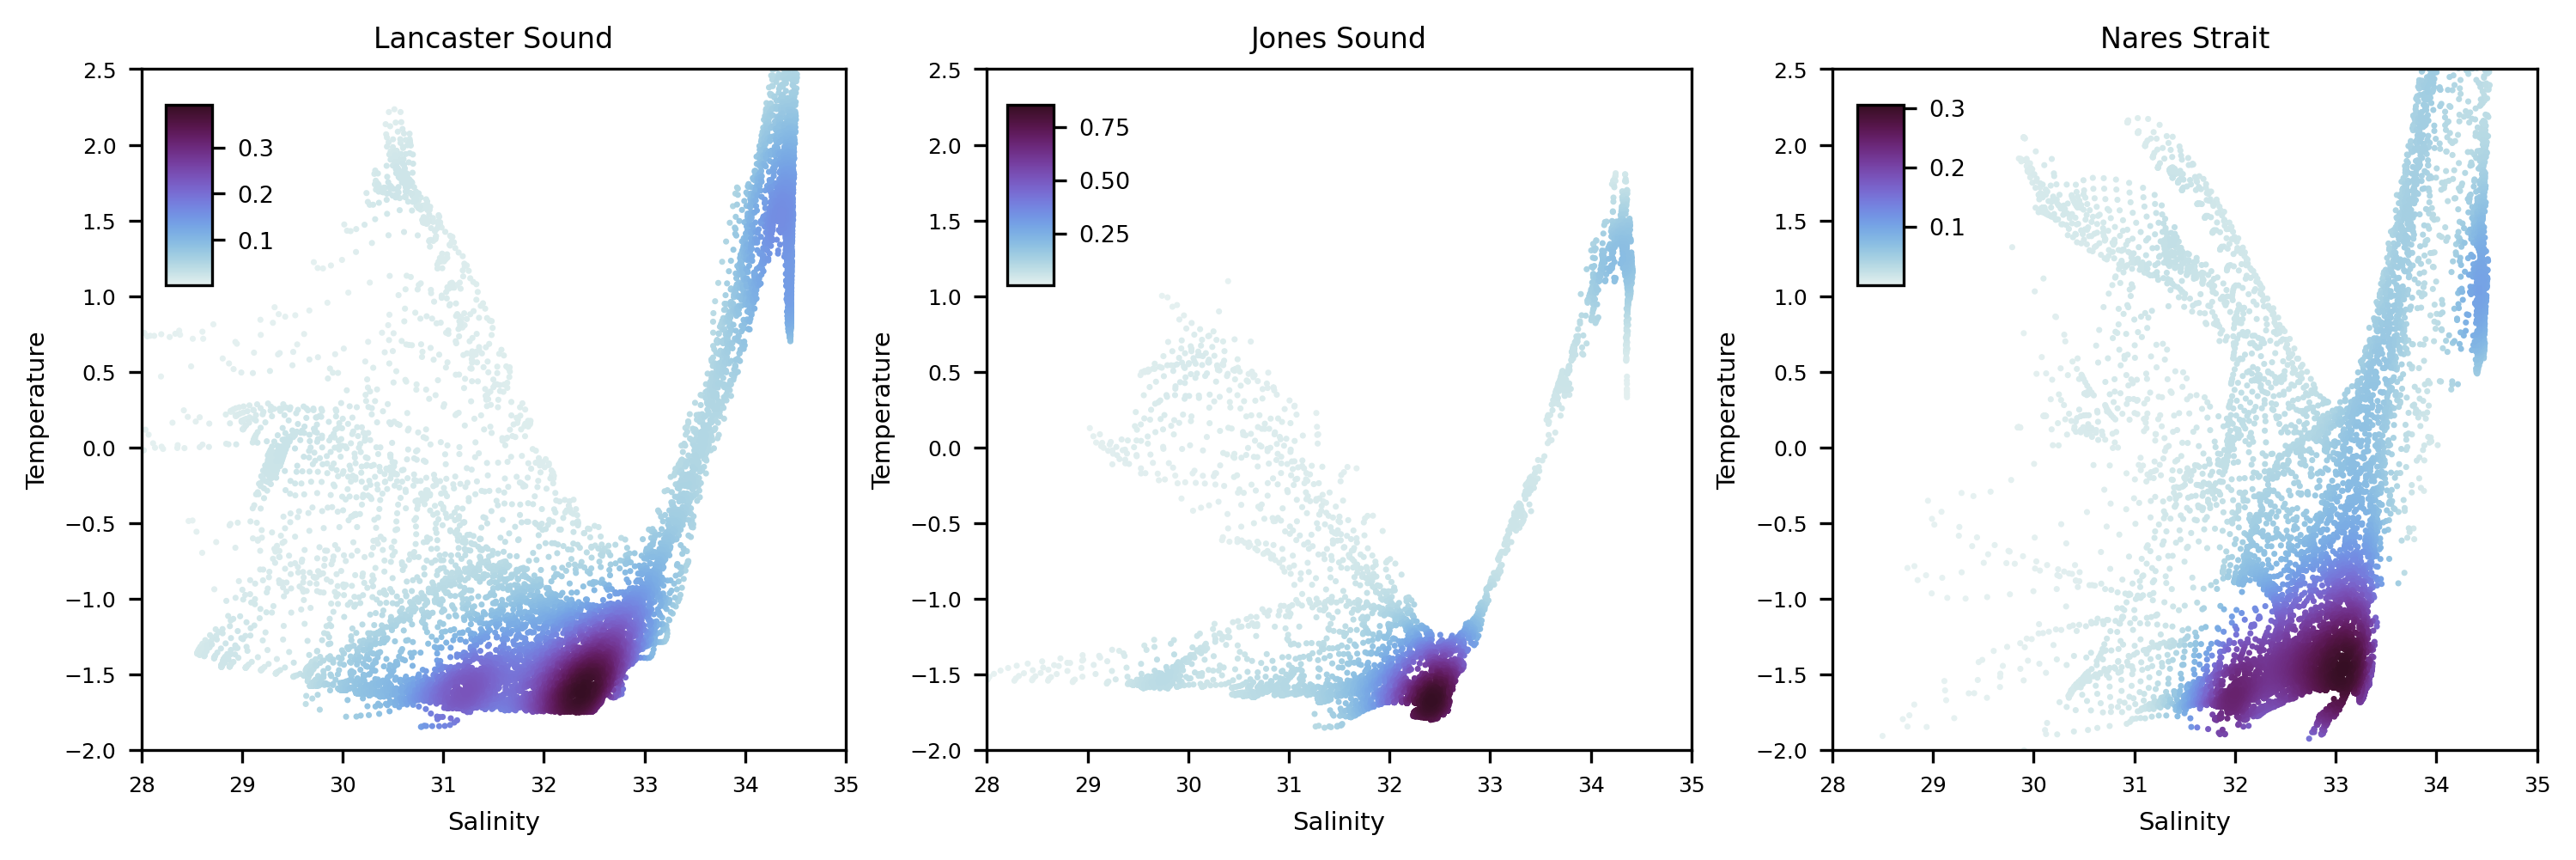

In [17]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5), dpi=300)

ax[0].set_title('Lancaster Sound', fontsize=8)
ax[1].set_title('Jones Sound', fontsize=8)
ax[2].set_title('Nares Strait', fontsize=8)

for n,axis in enumerate(ax.ravel()):
    axis.set_xlabel('Salinity', fontsize=7)
    axis.set_ylabel('Temperature', fontsize=7)
    axis.tick_params(labelsize=6)
    axis.set_xlim(28, 35)
    axis.set_ylim(-2.0, 2.5)
    
C1 = ax[0].scatter(xLS, yLS, c=zLS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)
C2 = ax[1].scatter(xJS, yJS, c=zJS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)
C3 = ax[2].scatter(xNS, yNS, c=zNS, s=0.5, zorder=1, alpha=1, cmap=cmocean.cm.dense)

cbaxes1 = fig.add_axes([0.133, 0.64, 0.015, 0.2]) 
cbaxes2 = fig.add_axes([0.405, 0.64, 0.015, 0.2]) 
cbaxes3 = fig.add_axes([0.680, 0.64, 0.015, 0.2]) 
CB1 = plt.colorbar(C1, cax=cbaxes1)
CB2 = plt.colorbar(C2, cax=cbaxes2)
CB3 = plt.colorbar(C3, cax=cbaxes3)
for CBar in [CB1, CB2, CB3]:
    CBar.ax.tick_params(labelsize=6.5)
#     CBar.ax.set_label('Depth [m]')    

# plt.tight_layout(h_pad = 0.2)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/boundary_2015-2016_monthly_TS.jpg', dpi=300, bbox_inches='tight')

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


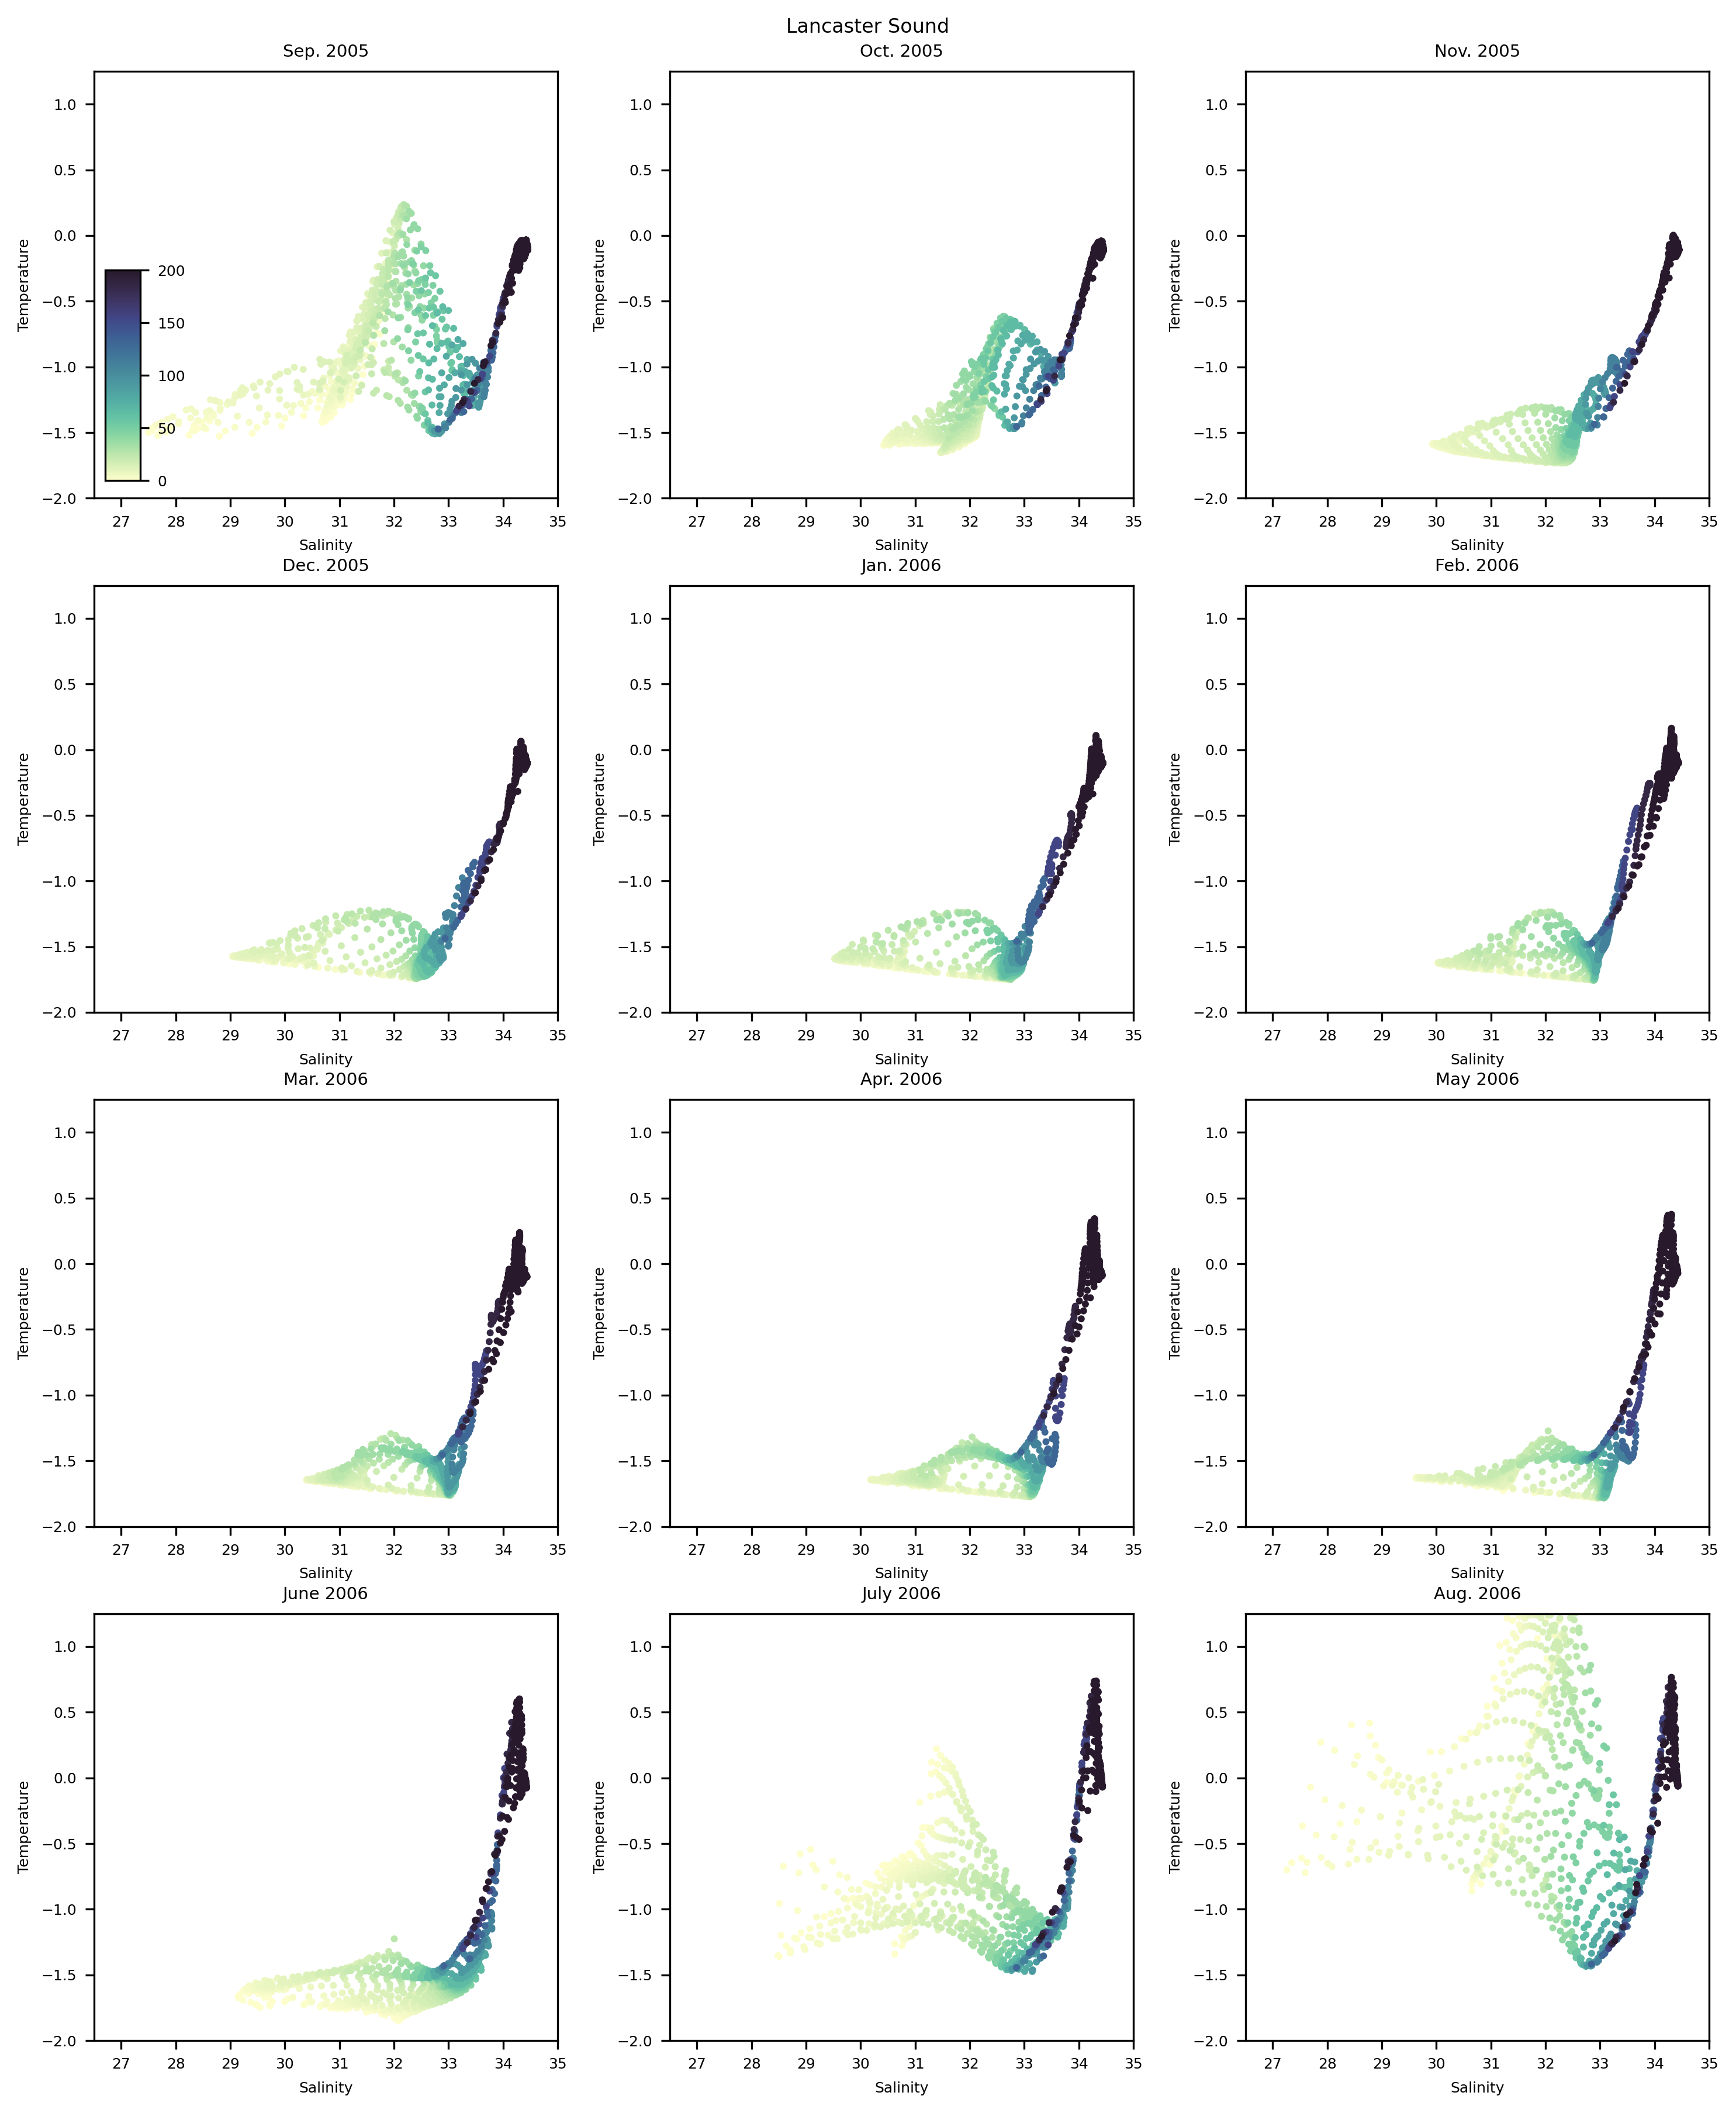

In [173]:
fig, ax = plt.subplots(4,3, figsize=(10,12), dpi=300)

fig.suptitle('Lancaster Sound', fontsize=8, y=1.00)

for n,axis in enumerate(ax.ravel()):
    axis.set_title(labels[n], fontsize=7)
    axis.set_xlabel('Salinity', fontsize=6)
    axis.set_ylabel('Temperature', fontsize=6)
    axis.tick_params(labelsize=6)
    axis.set_xlim(26.5, 35)
    axis.set_ylim(-2.0, 1.25)
    
    CB = axis.scatter(LS_S[n,:,:] , LS_T[n,:,:] , c=np.tile(ANHA12_depth,(LS_T.shape[2],1)).transpose(), \
                     s=3.5, zorder=1, alpha=1, cmap=cmocean.cm.deep, vmin=0, vmax=200)
    
cbaxes1 = fig.add_axes([0.065, 0.78, 0.02, 0.1]) 
CB1 = plt.colorbar(CB, cax=cbaxes1) # ticks=np.arange(0,1.1,0.1)
CB1.ax.tick_params(labelsize=6)

plt.tight_layout(h_pad = 0.2)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/LancasterSound_2005-2006_monthly_TS.jpg', dpi=300, bbox_inches='tight')

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


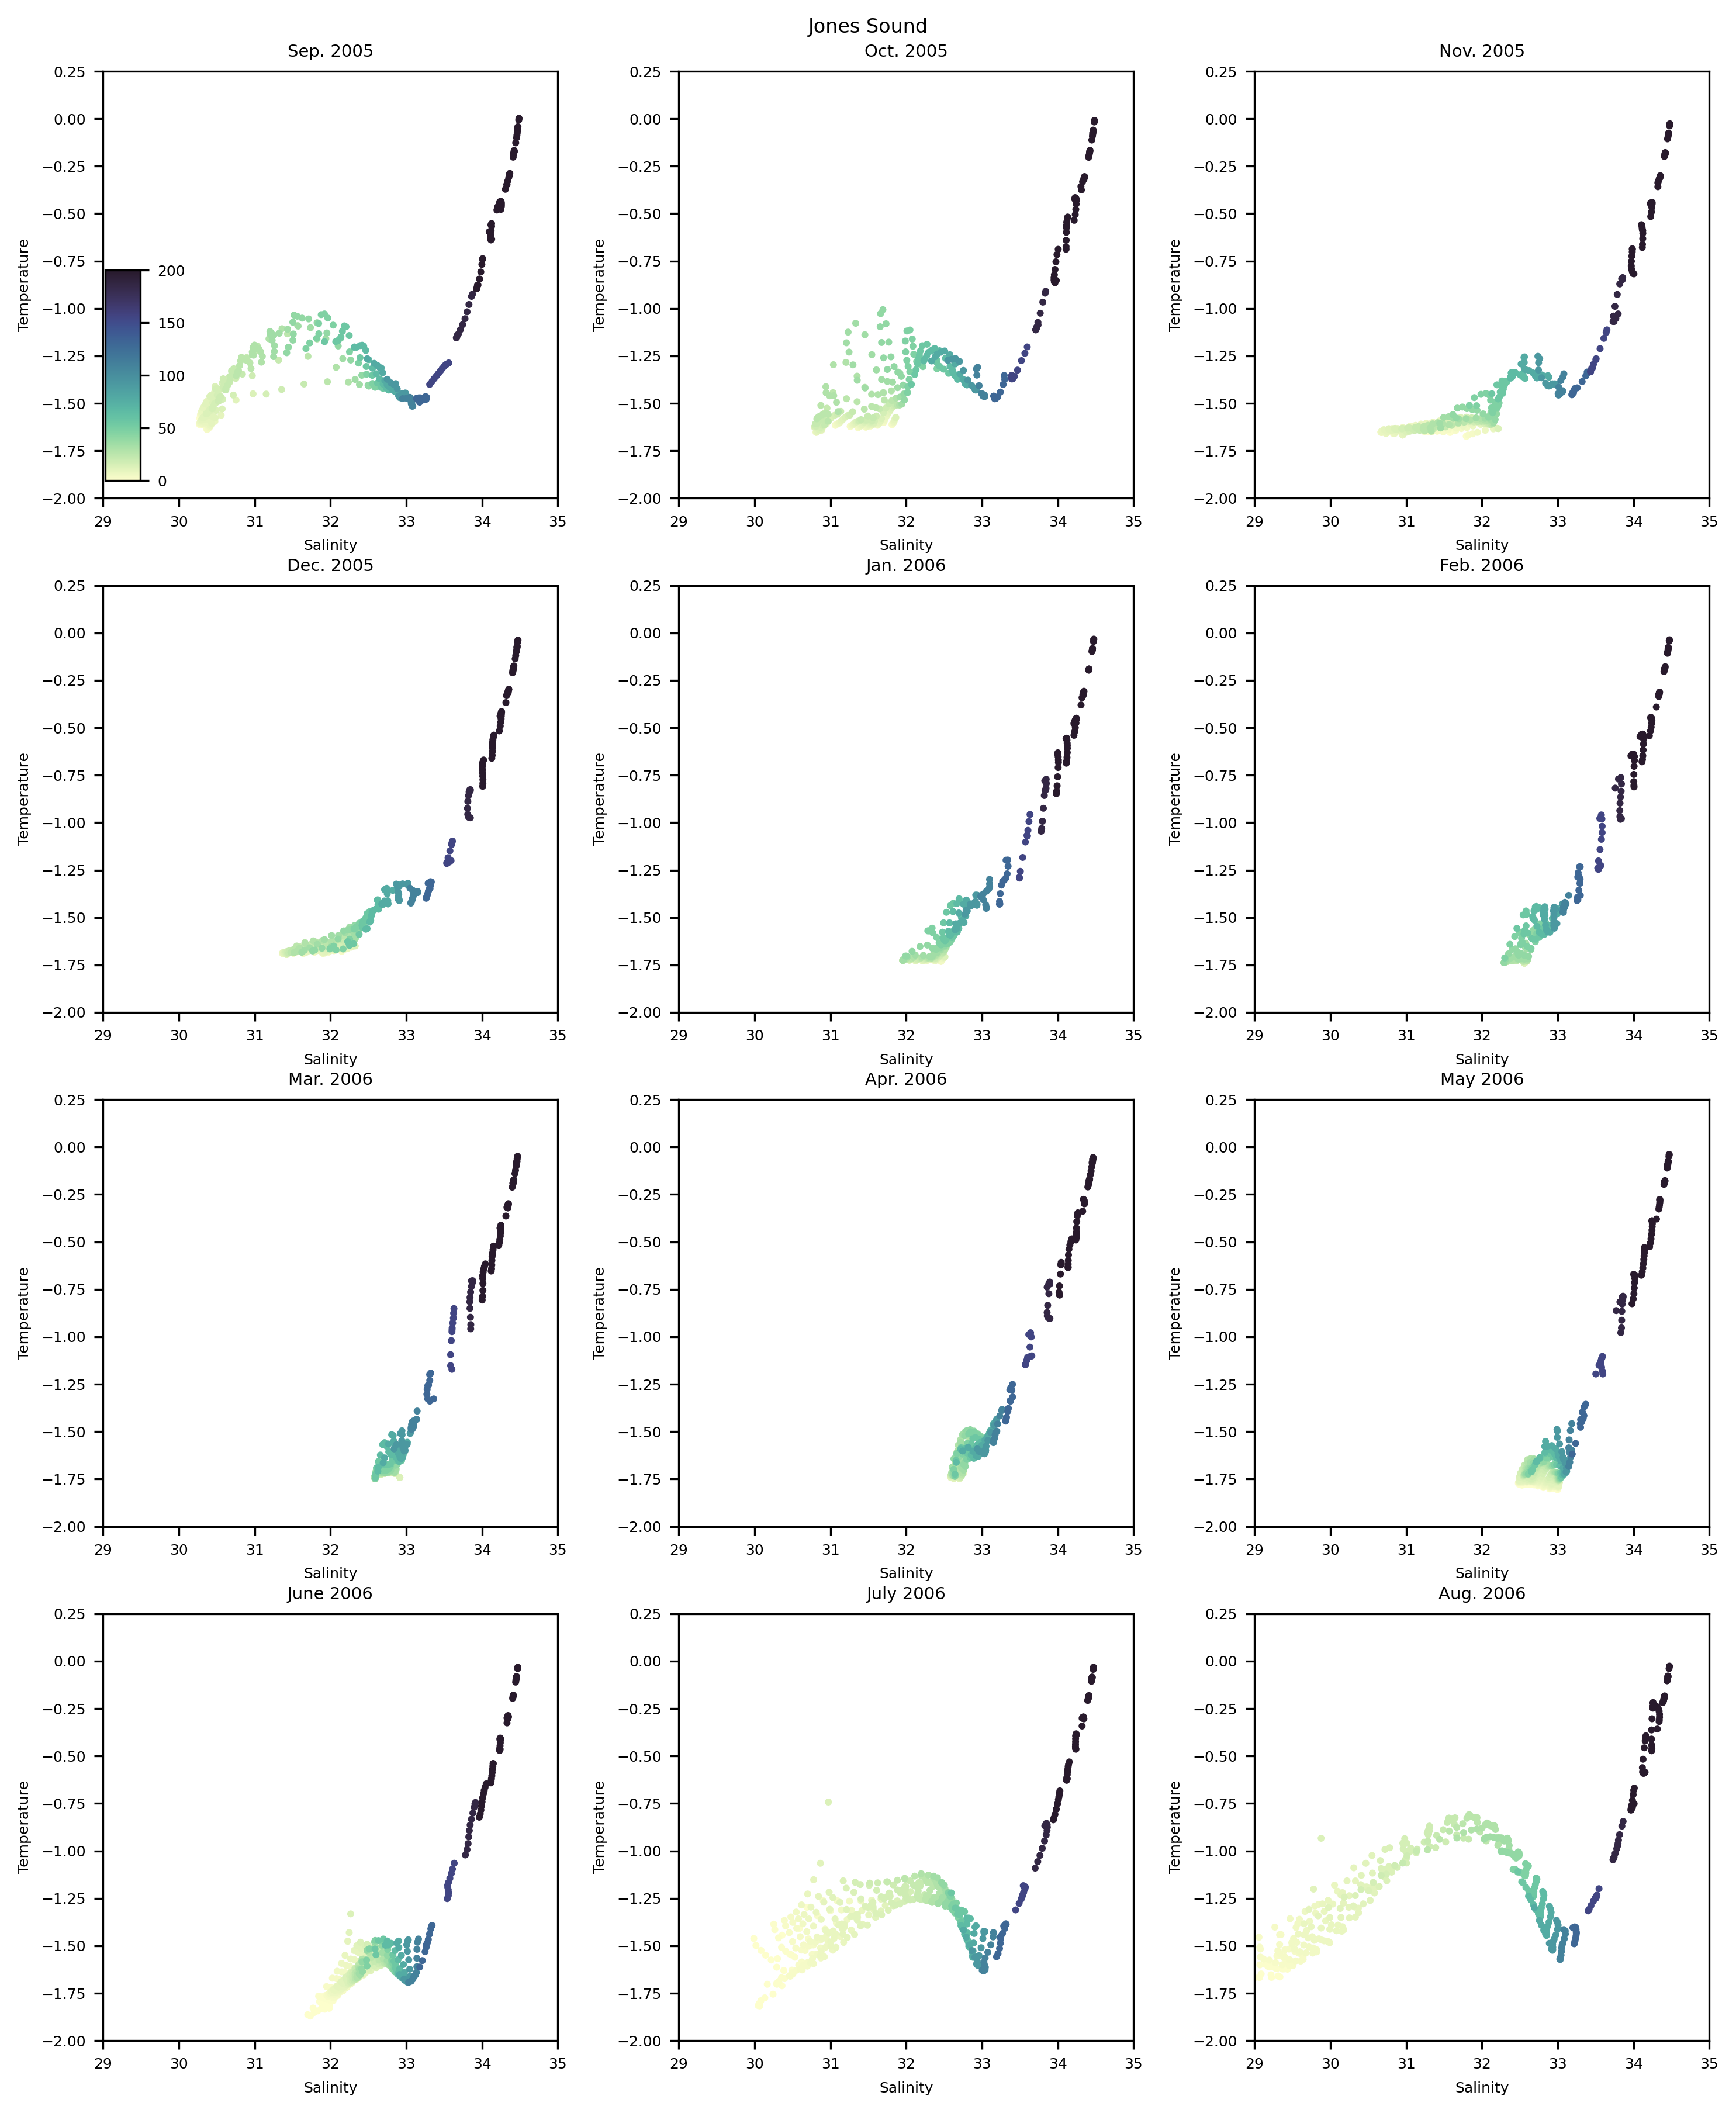

In [174]:
fig, ax = plt.subplots(4,3, figsize=(10,12), dpi=300)

fig.suptitle('Jones Sound', fontsize=8, y=1.00)

for n,axis in enumerate(ax.ravel()):
    axis.set_title(labels[n], fontsize=7)
    axis.set_xlabel('Salinity', fontsize=6)
    axis.set_ylabel('Temperature', fontsize=6)
    axis.tick_params(labelsize=6)
    axis.set_xlim(29, 35)
    axis.set_ylim(-2.0, 0.25)
    
    CB = axis.scatter(JS_S[n,:,:] , JS_T[n,:,:] , c=np.tile(ANHA12_depth,(JS_T.shape[2],1)).transpose(), \
                     s=3.5, zorder=1, alpha=1, cmap=cmocean.cm.deep, vmin=0, vmax=200)
    
cbaxes1 = fig.add_axes([0.065, 0.78, 0.02, 0.1]) 
CB1 = plt.colorbar(CB, cax=cbaxes1) # ticks=np.arange(0,1.1,0.1)
CB1.ax.tick_params(labelsize=6)

plt.tight_layout(h_pad = 0.2)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/JonesSound_2005-2006_monthly_TS.jpg', dpi=300, bbox_inches='tight')